# Tutorial x : Training Spiking Neural Networks using BPTT

**AMLD EPFL 2022**: Spiking Neural Networks for Low-Power Real-Time Inference

**By SynSense**

**Content creators**: Ugurcan Cakal

**Content reviewers**: Hannah Bos, Dylan Muir

This tutorial demonstrates using Rockpool and a torch-based single leaky integrate and fire neuron layer to perform gradient descent training of all network parameters. The spiking nerual network is trained on a representative toy task as it is easy but still requires temporal memory.

## Tutorial Objectives
**Estimated timing**: 30 minutes

In this tutorial, we will investigate:

* Rockpool SNN implementation
* What a surrogate gradient is and why it's necessary?
* How to train spiking neural networks using troch gradient mechanics to update weight and time constant parameters

### TODOS
* Use tonic instead of torch dataset or do not use dataset at all.
    * It might be better to introduce if it helps Hannah
* Explain in seconds instead of in timesteps
* Maybe explain BPTT a bit
* Maybe explain TSEvent and TSContinuous a bit
* Try with StepPWL instead of PeriodicExponential
* Use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor)
* Explain network, LinearTorch, LIFTorch and Sequential combinator
* A utility function to plot all Vmem, Isyn and etc.
* Tex formatting to figures like Vmem
* Figure titles
* Slightly explain loss function, activation function, gradient descent, adam optimizer and training loop
* Try to add output linear
* If not enough, go add two or more neurons, increase model complexity and do it again
* add bound loss
* what happens with negative weights and positive weights?
* work on input dimensionality

### Interaction
* Changing delay
* What if we want to train time constants?
    * Add dt bounds >0
* What if we already know some constraints?
    * Add lower and upper bounds


In [2]:
# - Ignore warnings
import warnings
warnings.filterwarnings('ignore')
# Rockpool Imports
from rockpool.timeseries import TSEvent, TSContinuous
from rockpool.nn.modules import LIFTorch, LinearTorch
from rockpool.nn.combinators import Sequential
from rockpool.parameters import Constant
from rockpool.nn.modules.torch.lif_torch import PeriodicExponential
from typing import Dict
from utils import plot_LIF_record, one_spike_sample, poisson_spike_train, RateReadout, plot_signal, plot_raster

# Torch Imports
import torch
from torch import nn
from torch.optim import Adam

# Numpy
import numpy as np
from tqdm import tqdm

# - Plotting imports and config
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 300

## Section 1: Rockpool Modules

In [3]:
dt = 1e-3

lin_0 = LinearTorch((1, 1), weight = torch.tensor([[.5]]), has_bias=False)
neuron_0 = LIFTorch((1, 1), spike_generation_fn=PeriodicExponential)
readout_0 = RateReadout((1,1), dt=dt)
model_0 = Sequential(lin_0, neuron_0, readout_0)

model_0

TorchSequential  with shape (1, 1) {
    LinearTorch '0_LinearTorch' with shape (1, 1)
    LIFTorch '1_LIFTorch' with shape (1, 1)
    RateReadout '2_RateReadout' with shape (1, 1)
}

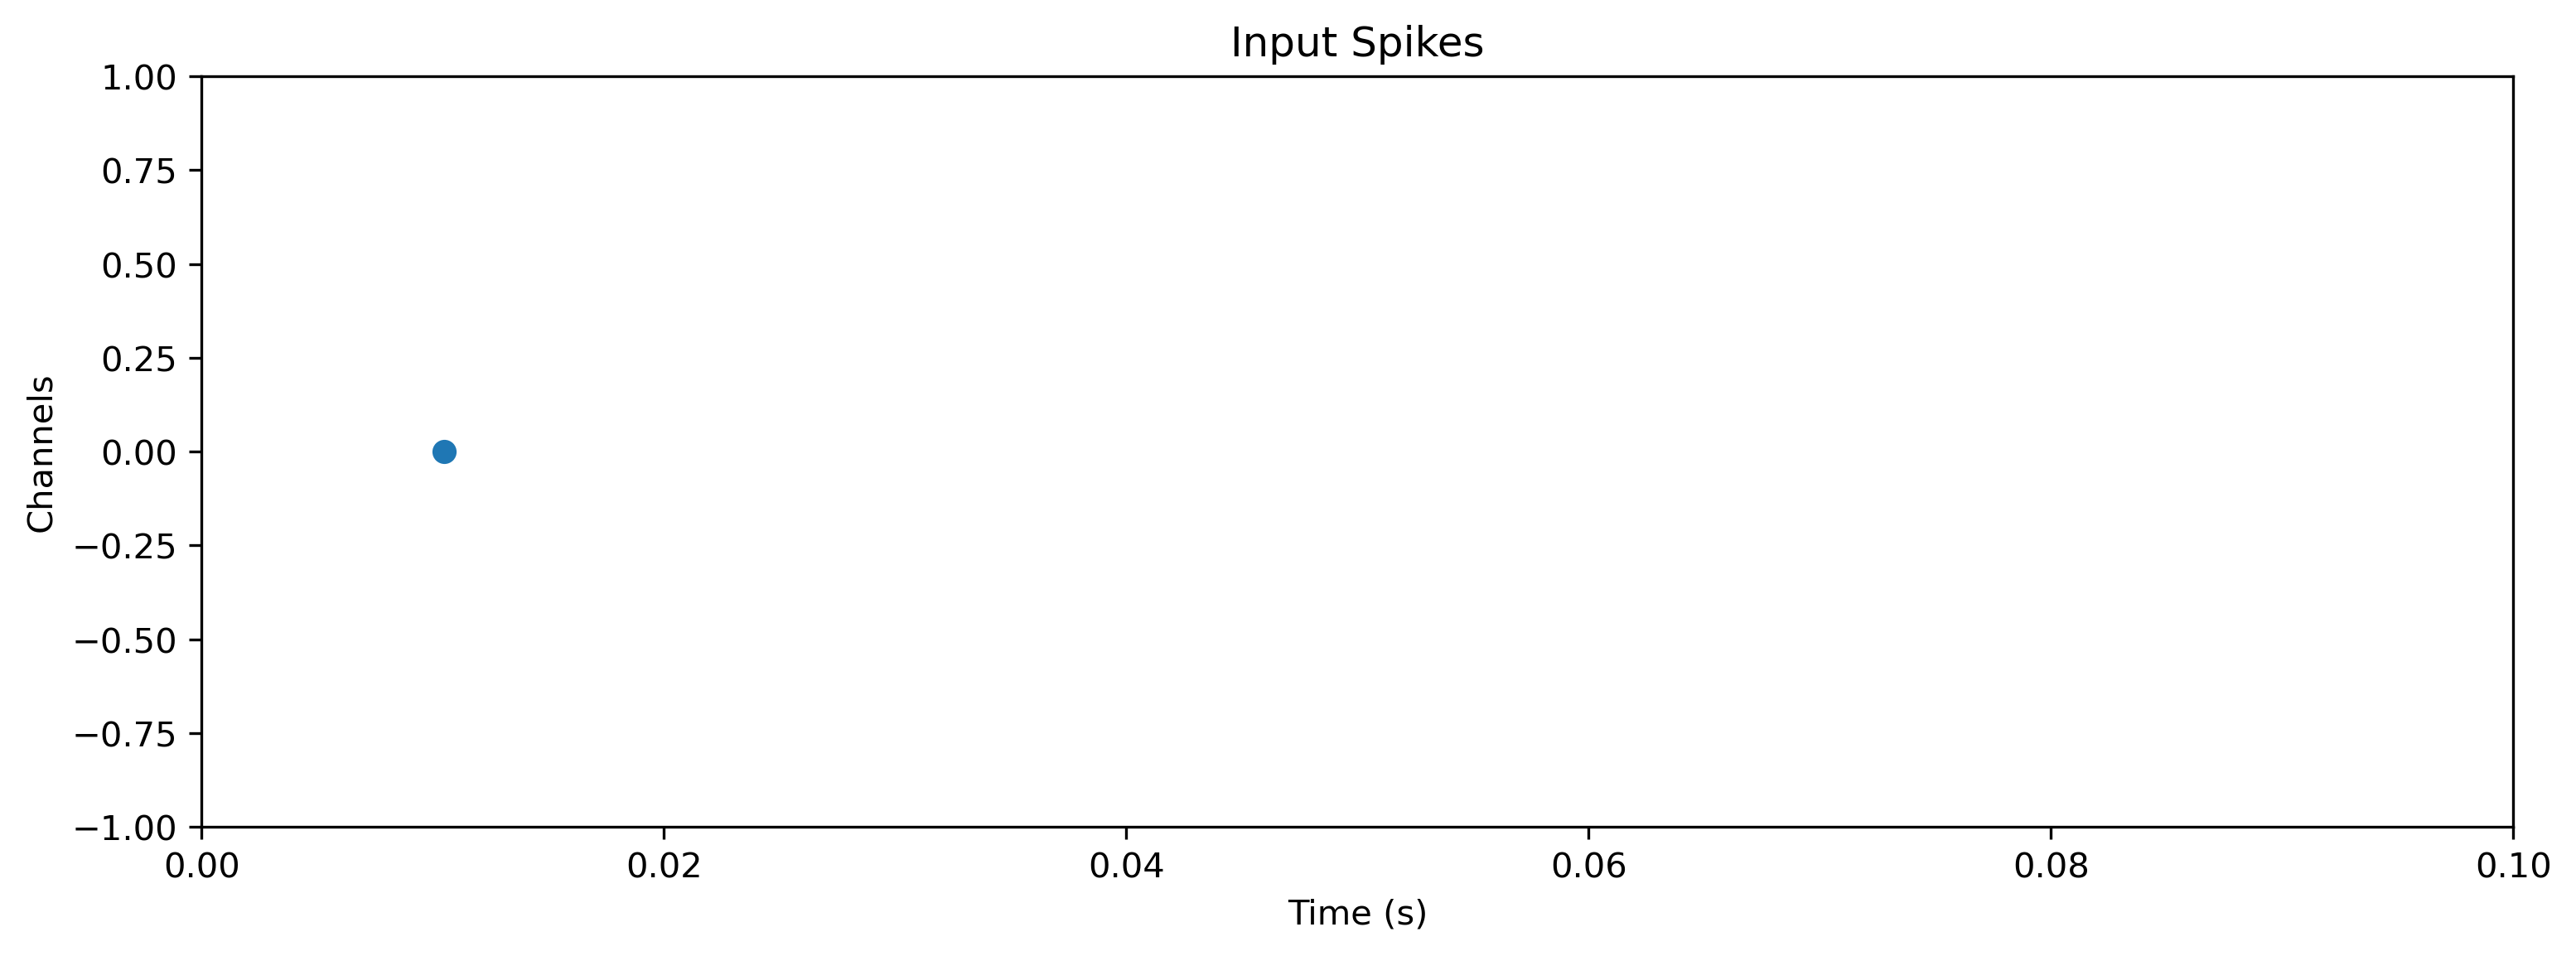

In [5]:
_input = one_spike_sample(t_spike=10e-3, duration=100e-3, dt=dt)
plot_raster(_input, "Input Spikes", dt)

In [6]:
model_0.reset_state()
tsOutput_0, new_state_0, record_dict_0 = model_0(_input[0], record = True)

### Model Output

In [7]:
print(tsOutput_0)

tensor(70., grad_fn=<DivBackward0>)


### Model State

In [8]:
new_state_0.keys()

dict_keys(['0_LinearTorch', '1_LIFTorch', '2_RateReadout'])

In [9]:
new_state_0["0_LinearTorch"]

{}

In [10]:
new_state_0["1_LIFTorch"]

{'vmem': tensor([0.3228]), 'isyn': tensor([[0.0056]]), 'spikes': tensor([0.])}

In [11]:
new_state_0["2_RateReadout"]

{}

### Record Dictionary

In [12]:
record_dict_0.keys()

dict_keys(['0_LinearTorch', '0_LinearTorch_output', '1_LIFTorch', '1_LIFTorch_output', '2_RateReadout', '2_RateReadout_output'])

In [13]:
record_dict_0["0_LinearTorch"]

{}

In [14]:
record_dict_0["2_RateReadout"]

{}

# Intermediate Steps

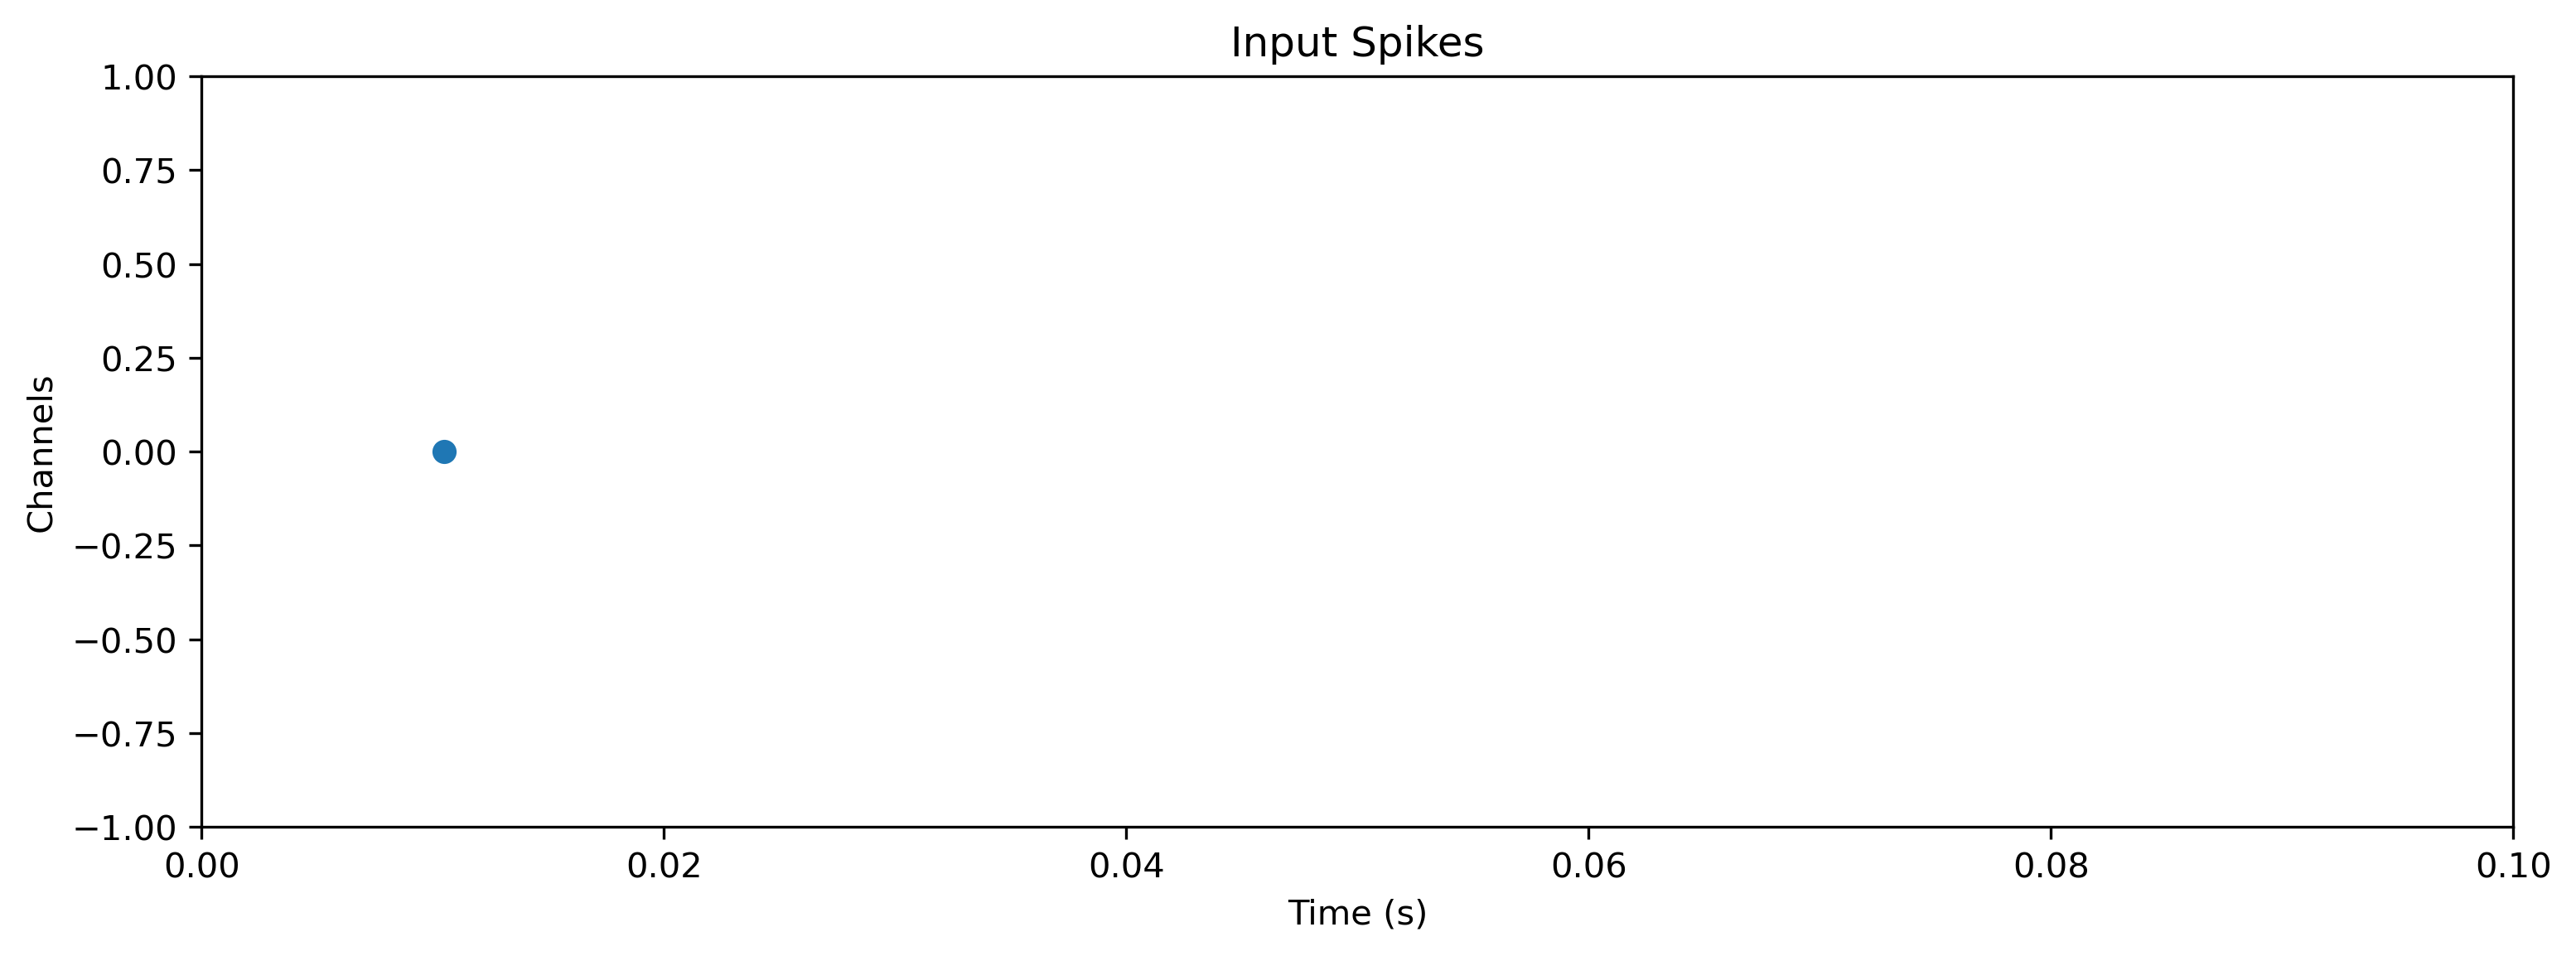

In [17]:
plot_raster(_input, "Input Spikes", dt)

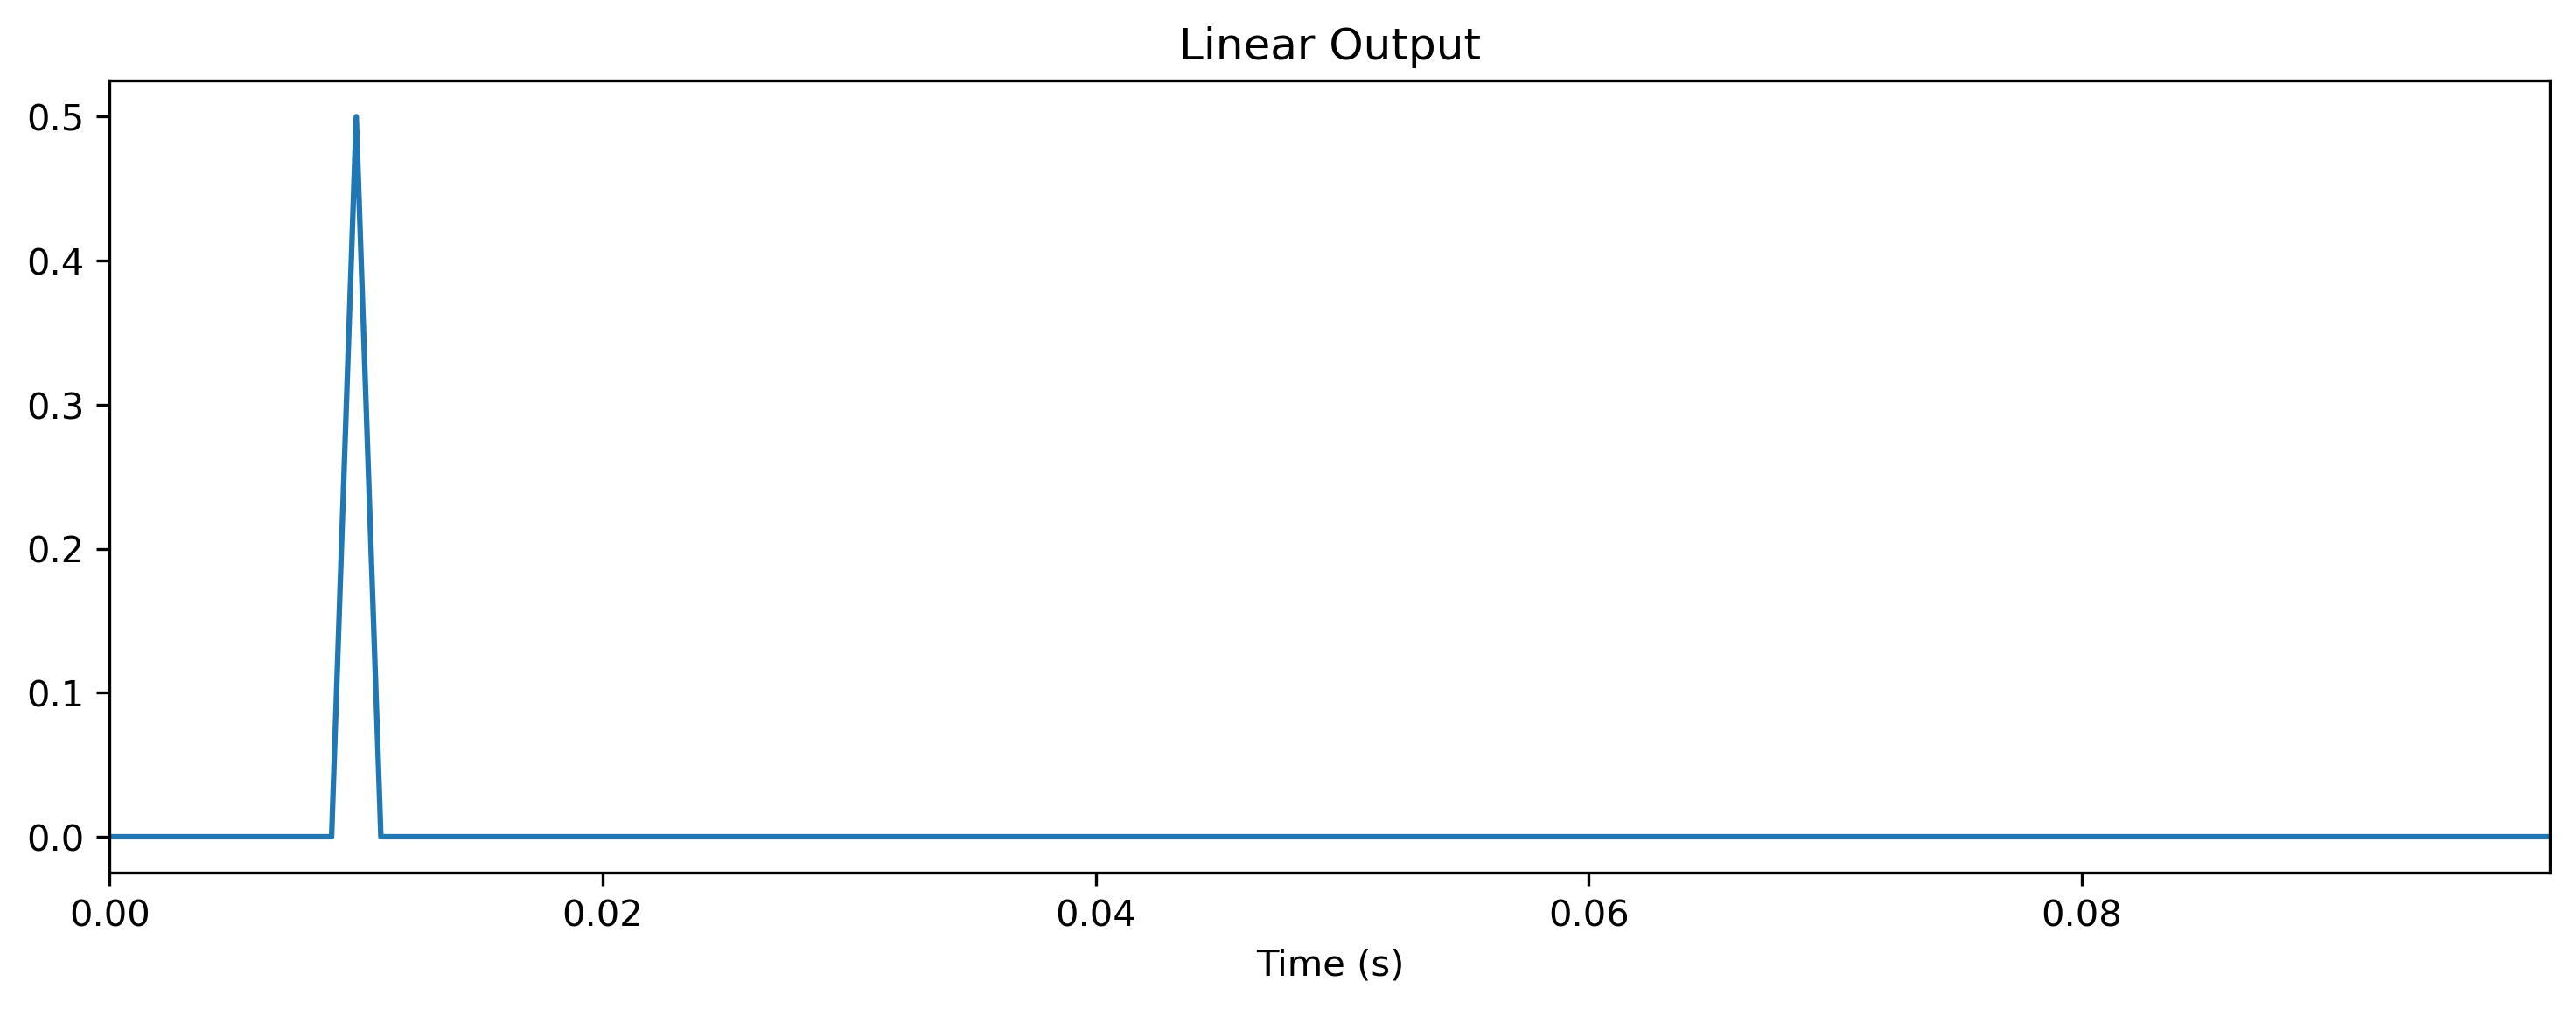

In [18]:
# Stateless
plot_signal(record_dict_0["0_LinearTorch_output"], "Linear Output", "", dt)

#### LIFTorch Record

In [19]:
record_dict_0["1_LIFTorch"].keys()

dict_keys(['vmem', 'isyn', 'spikes', 'irec', 'U'])

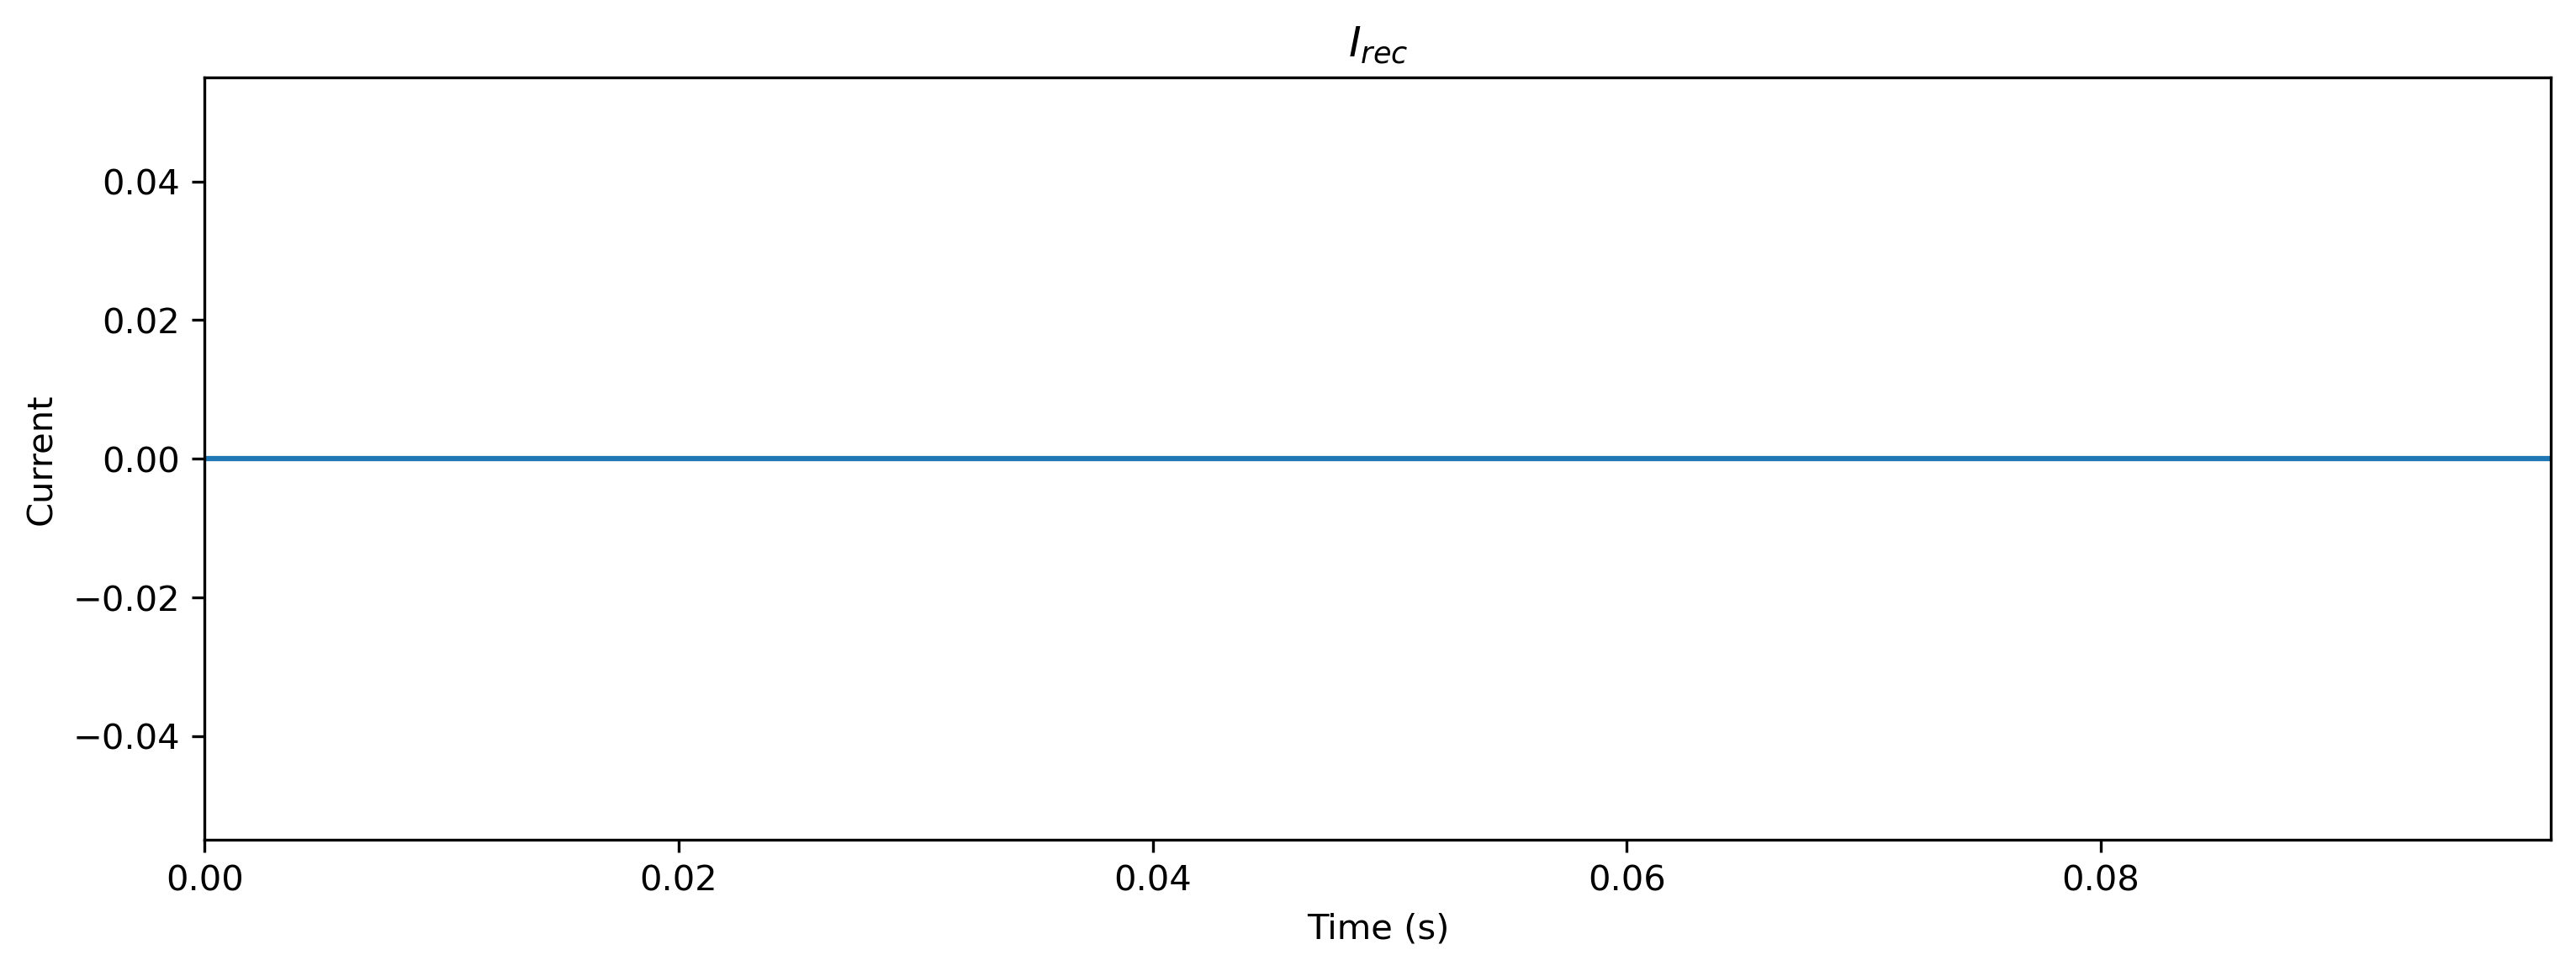

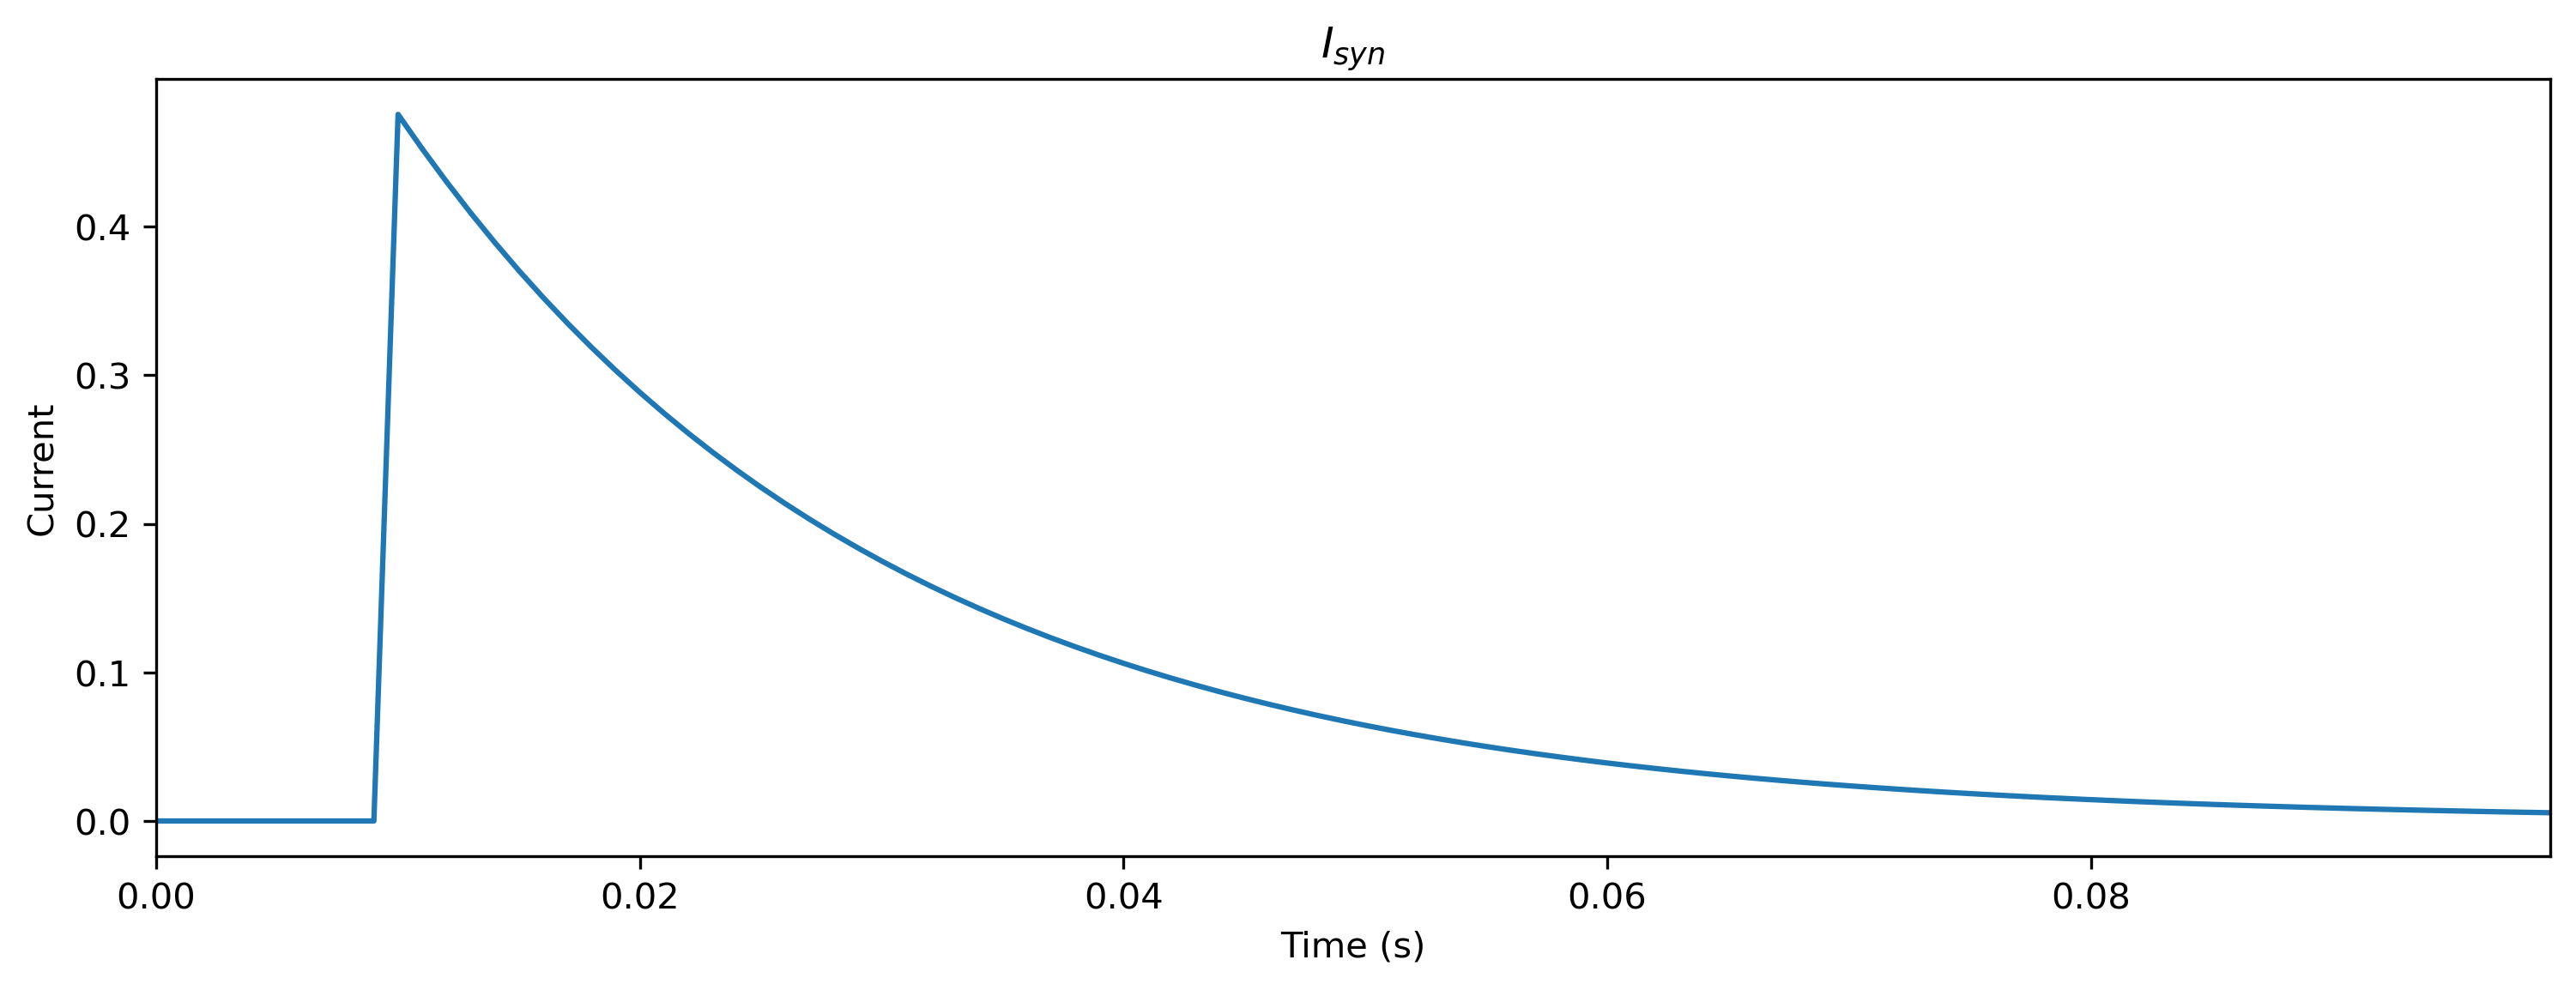

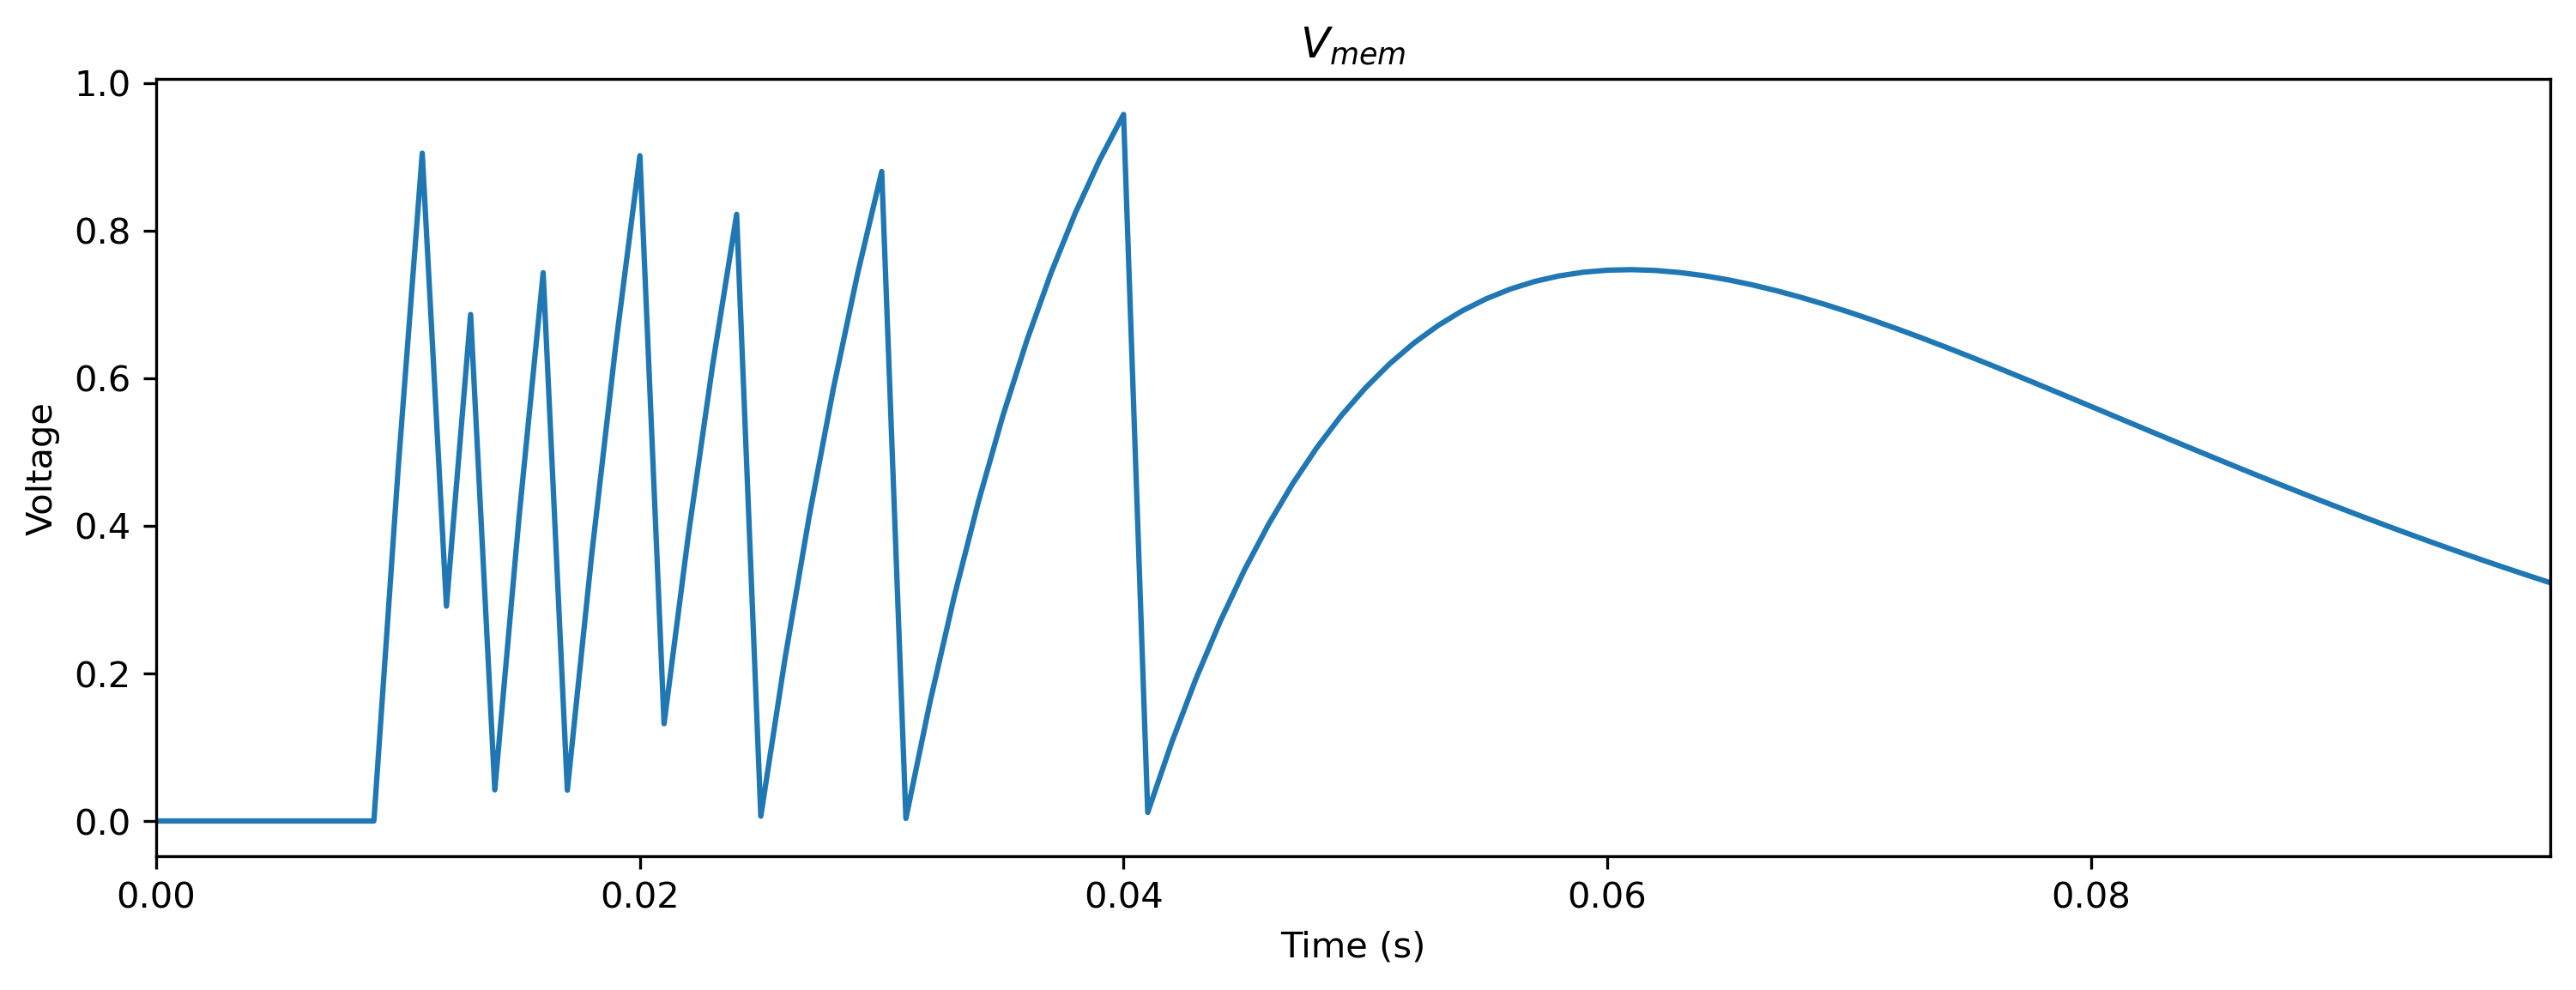

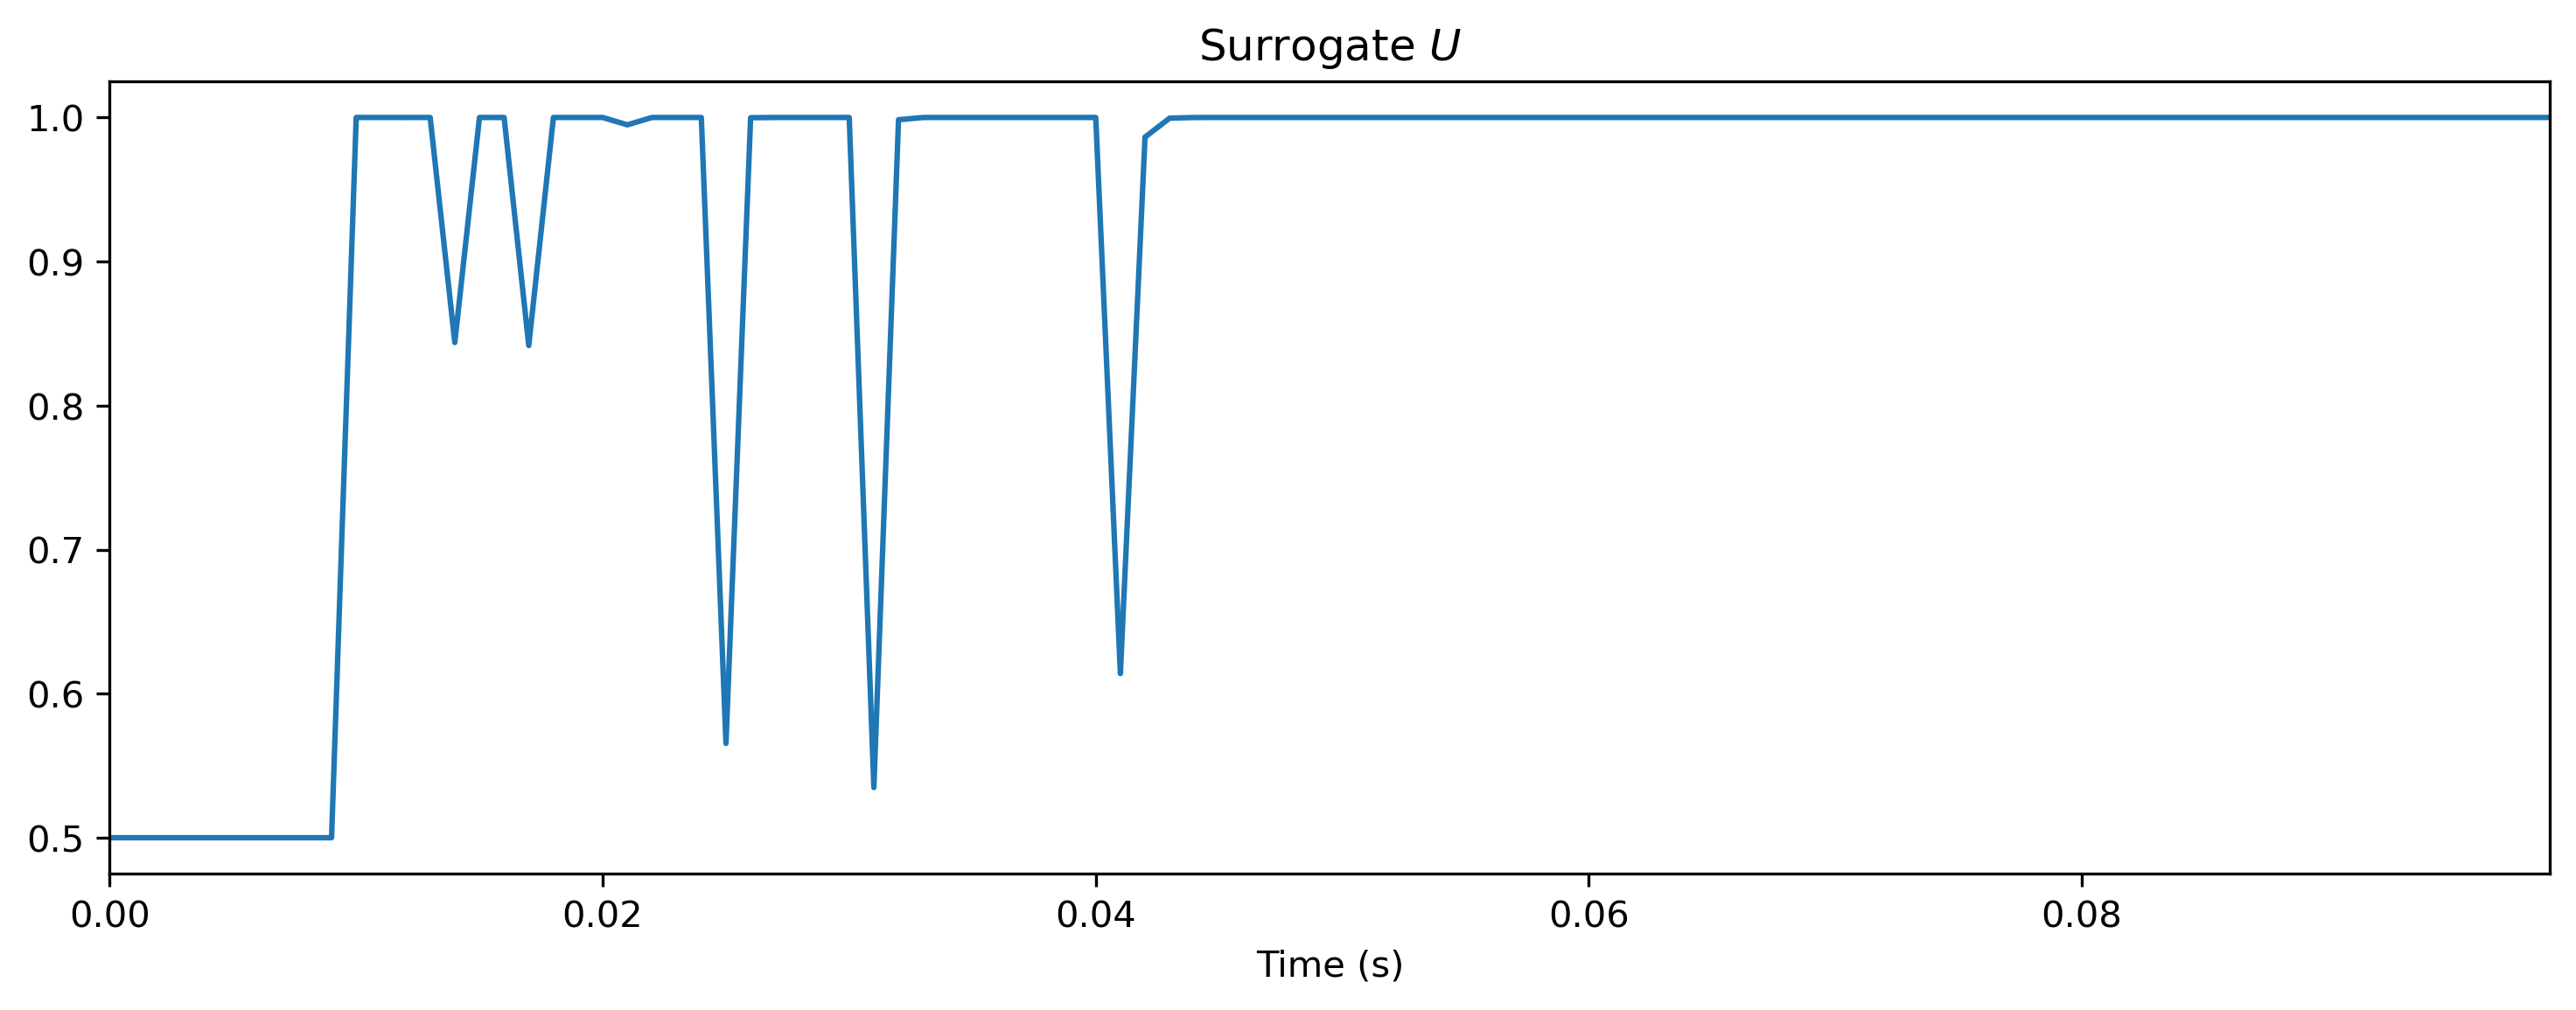

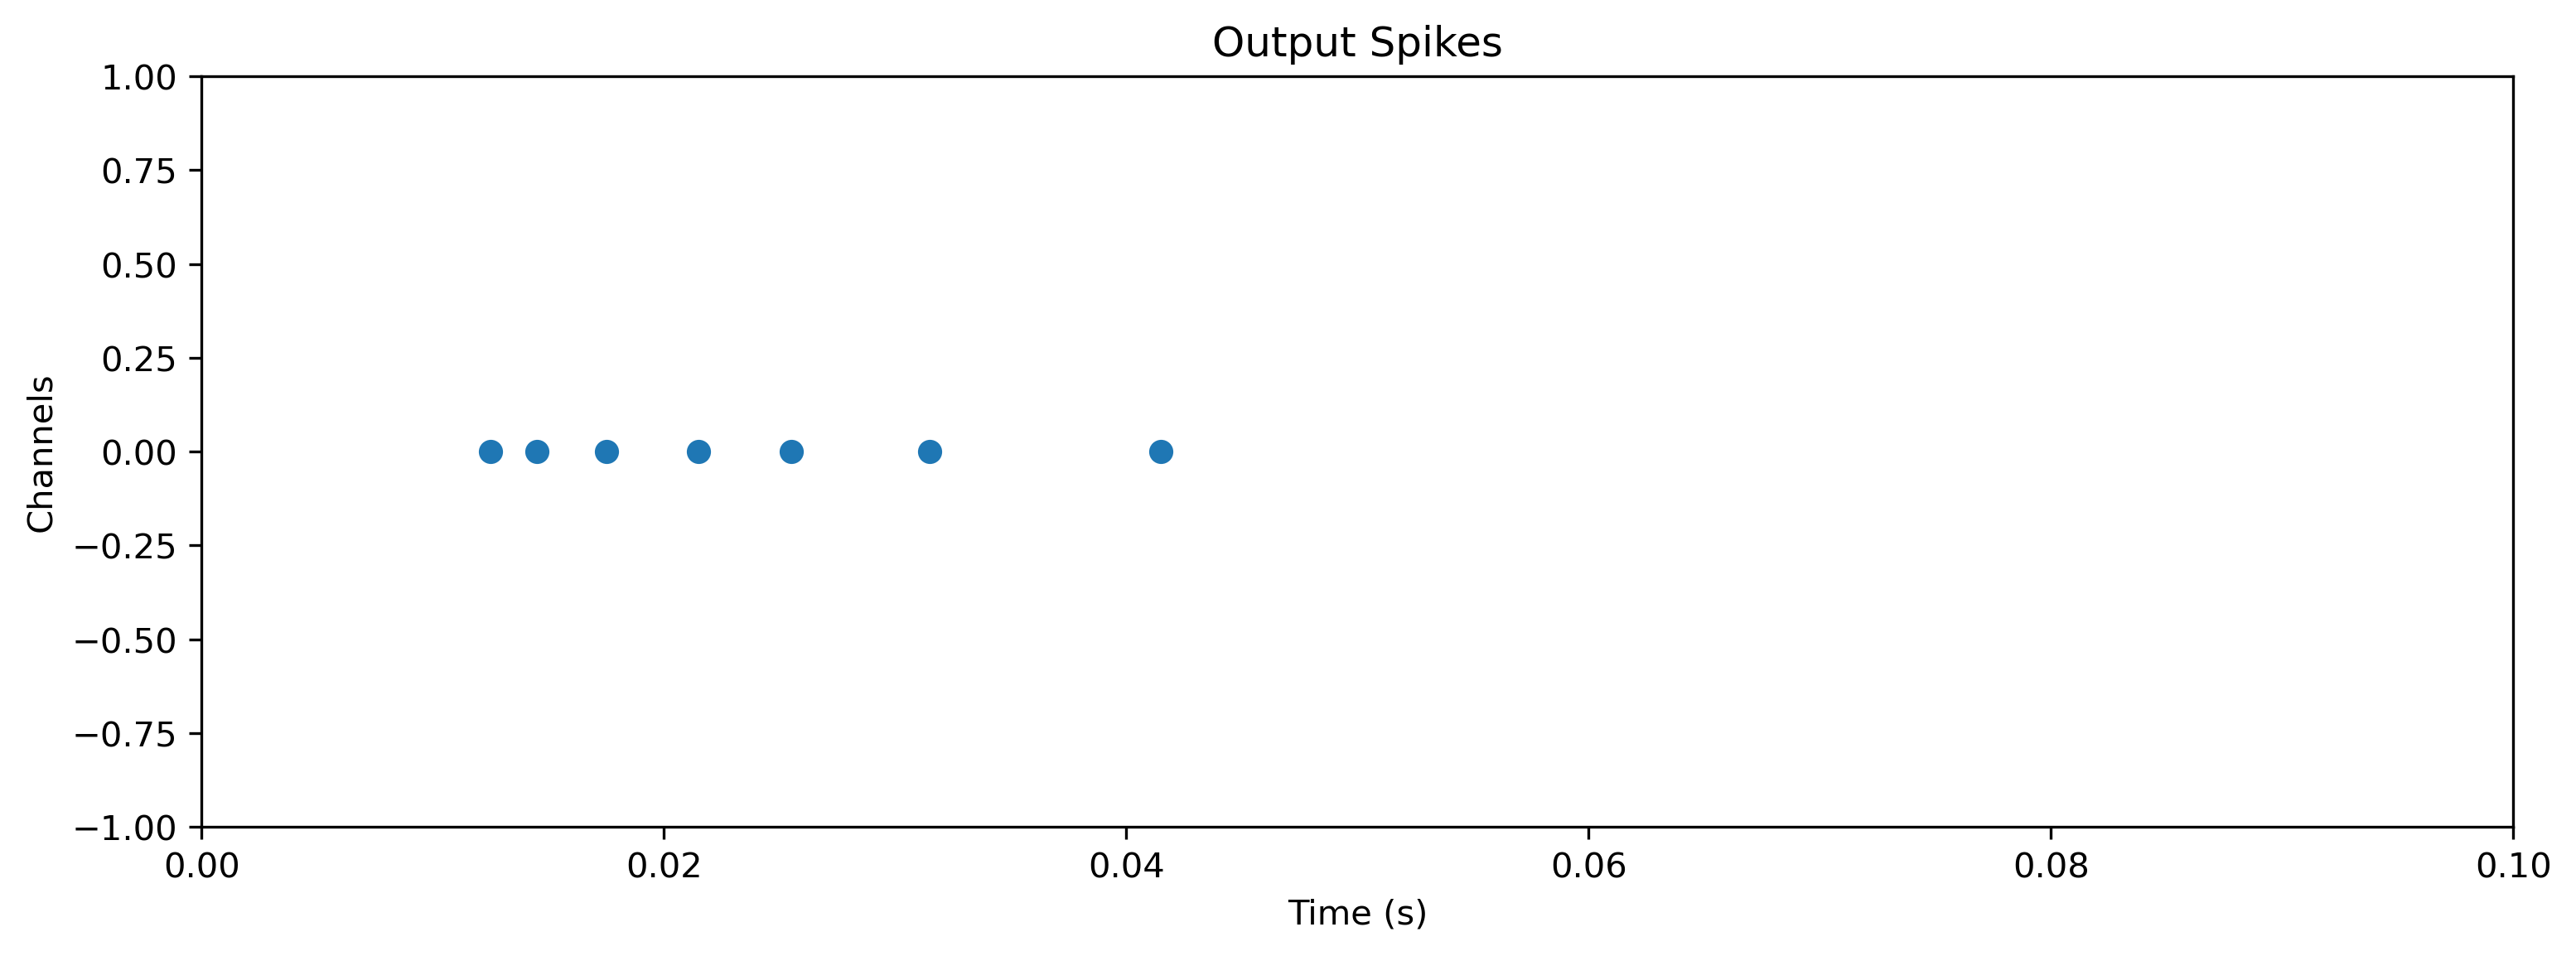

In [20]:
plot_LIF_record(record_dict_0['1_LIFTorch'], plot_Irec=True)

In [33]:
print(tsOutput_0)

tensor(70., grad_fn=<DivBackward0>)


## Section 2: Surrogate Gradients



## Section 3: Define task and visualize data

In the next cell we have provided code to load the data and plot the input and target response.

### Spike Delay Task

In this very simple task, we want to produce an output spike a certain amount of timesteps after a single input spike. With this task, we can investigate the duration of temporal memory of our network (or neurons) by systematically increasing the delay between input and output spike.

For starters, we define a trial to be $100$ timesteps long and generate an input spike at $T_{stim} = 10$ and expect an output spike $T_{delay} = 20$ timesteps after the input. $T_{target} = T_{stim} + T_{delay}$

In [21]:
# inp = uniform_spike_rate(duration=100e-3, rate=100.0, dt=dt)
inp = poisson_spike_train(duration=100e-3, rate=200.0, dt=dt)
tgt = torch.tensor(50.0)

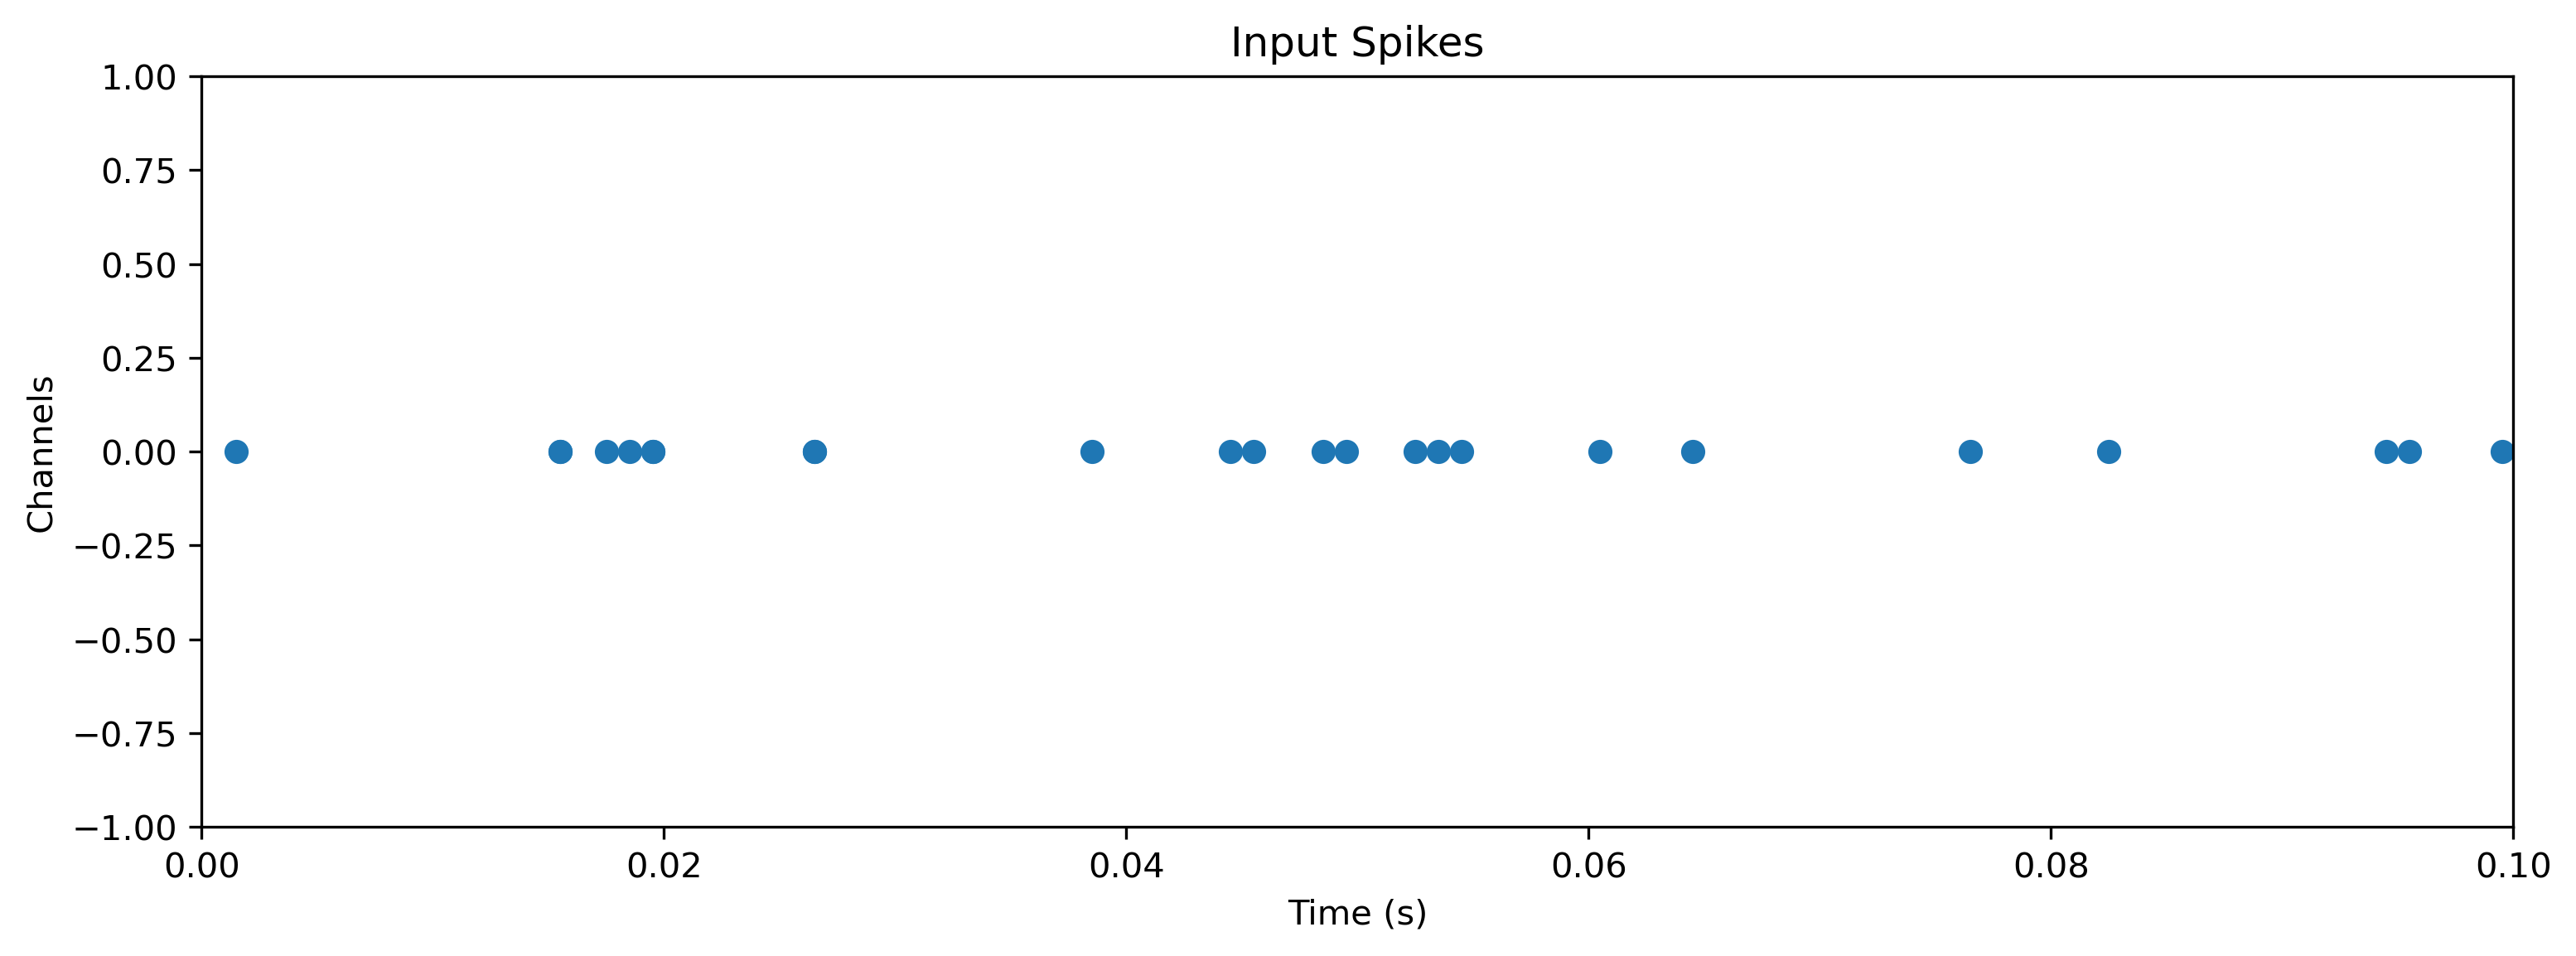

In [24]:
plot_raster(inp, "Input Spikes", dt)


## Section 3 : Training a Spiking Neural Network

In [25]:
lin_0 = LinearTorch((1, 1), has_bias=False)

neuron_0 = LIFTorch((1, 1),
                  tau_mem=Constant(0.03),
                  tau_syn=Constant(0.03),
                  bias=Constant(0.),
                  threshold=Constant(1.),
                  spike_generation_fn=PeriodicExponential,
                  learning_window=100.,
                  dt=0.001)

readout_0 = RateReadout((1,1), dt= dt)

model = Sequential(lin_0, neuron_0, readout_0)

model


TorchSequential  with shape (1, 1) {
    LinearTorch '0_LinearTorch' with shape (1, 1)
    LIFTorch '1_LIFTorch' with shape (1, 1)
    RateReadout '2_RateReadout' with shape (1, 1)
}

In [26]:
crit = nn.MSELoss()
optim = Adam(model.parameters().astorch(), lr=1e-1)
param_trace = []
loss_trace = []
grad_trace = []

for i in tqdm(range(1000)):
    model.reset_state()
    optim.zero_grad()
    out, state, rec = model.evolve(inp[0], record=True)
    
    loss = crit(tgt, out)
    loss_trace.append(loss.item())
    
    if loss == 0:
        break
        
    loss.backward()
    optim.step()
    
    param_trace.append(model._modules['0_LinearTorch'].weight.data[0, 0].item())
    grad_trace.append(model._modules['0_LinearTorch'].weight.grad[0, 0].item())

  5%|▌         | 53/1000 [00:02<00:45, 20.99it/s]


## Section 4 : Analyzing the Results

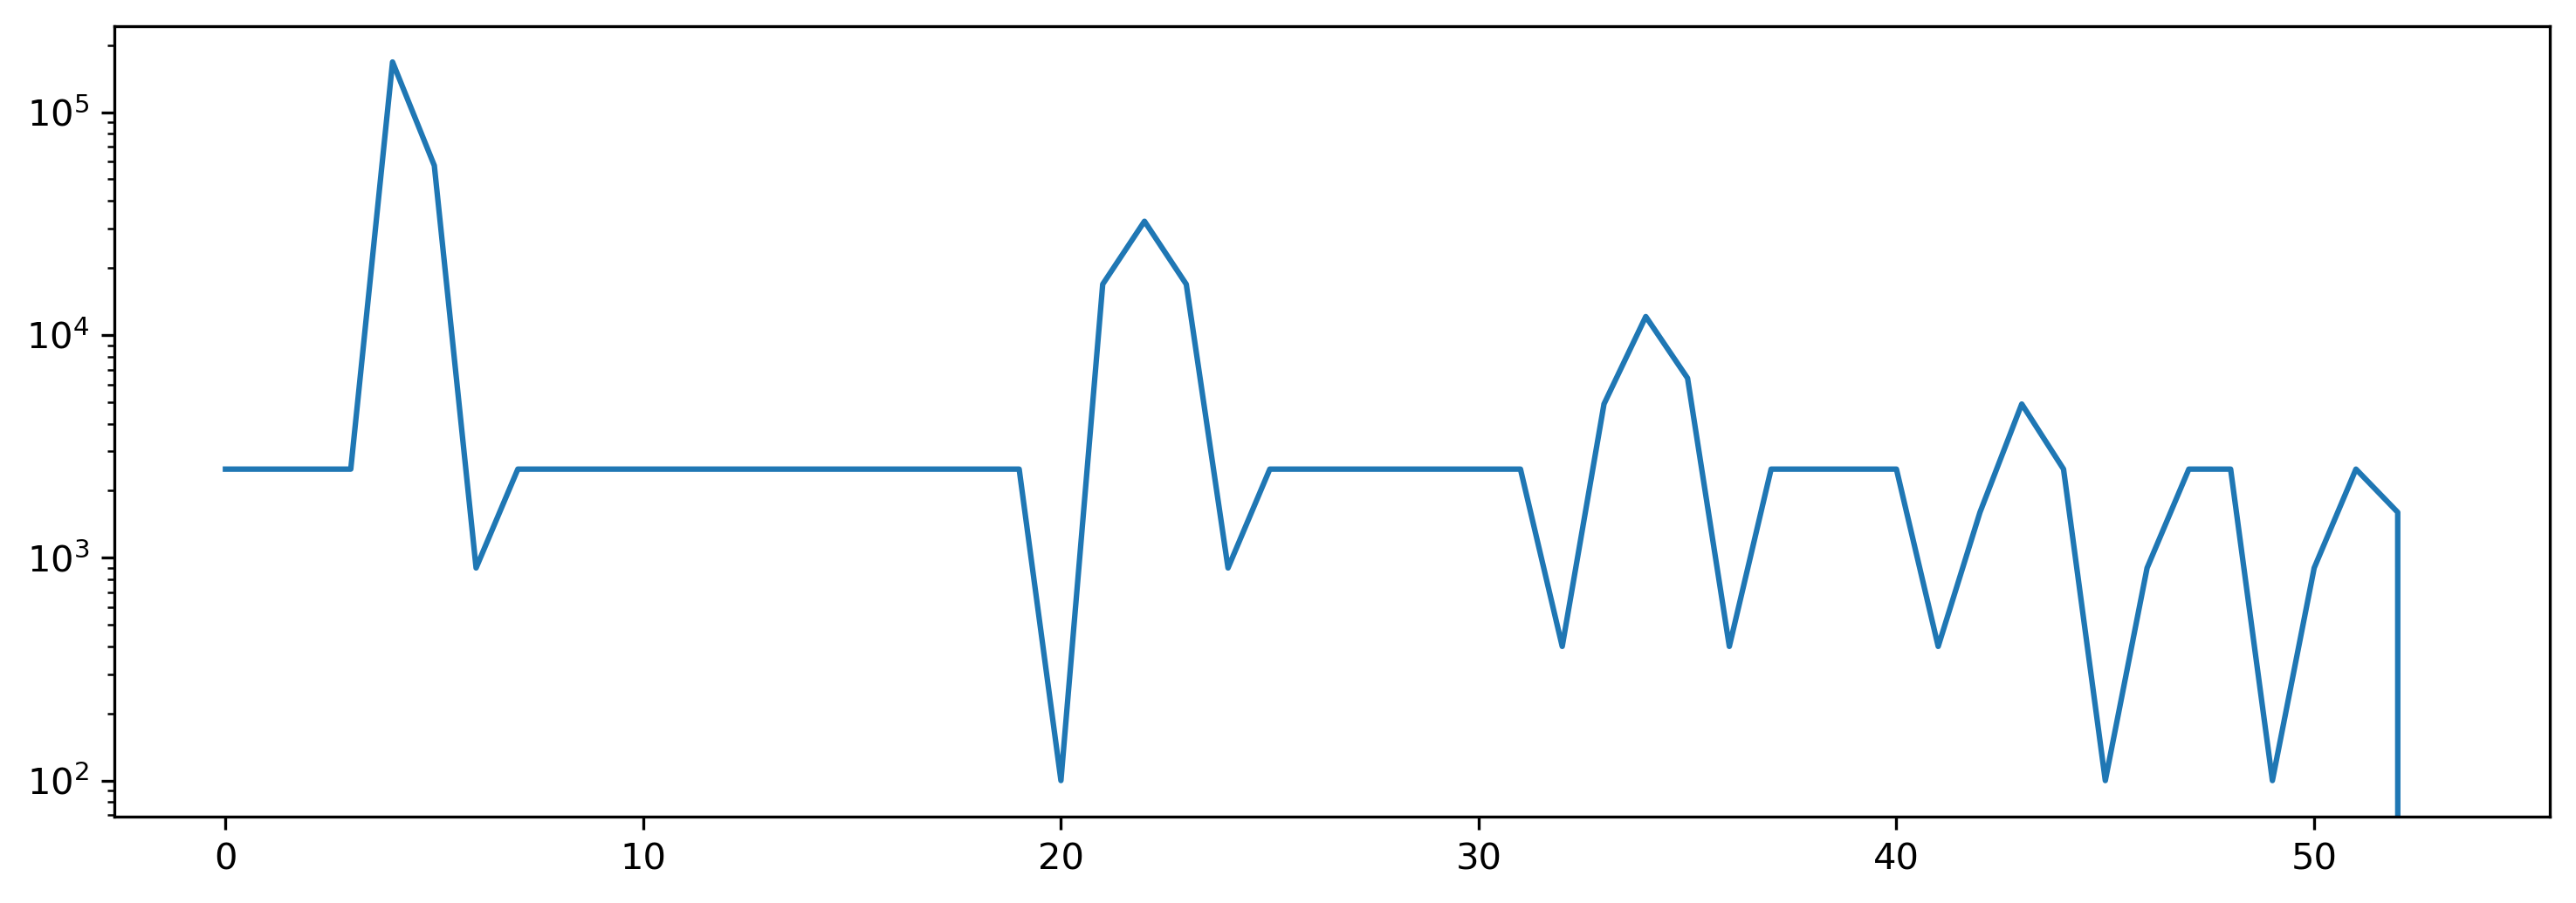

In [27]:
plt.plot(loss_trace)
plt.yscale("log")

In [28]:
modIn = model[0]
modLIF = model[1]

In [29]:
# Explore tau and weight change

In [30]:
model.reset_state()
out, state, rec = model(inp[0], record=True)

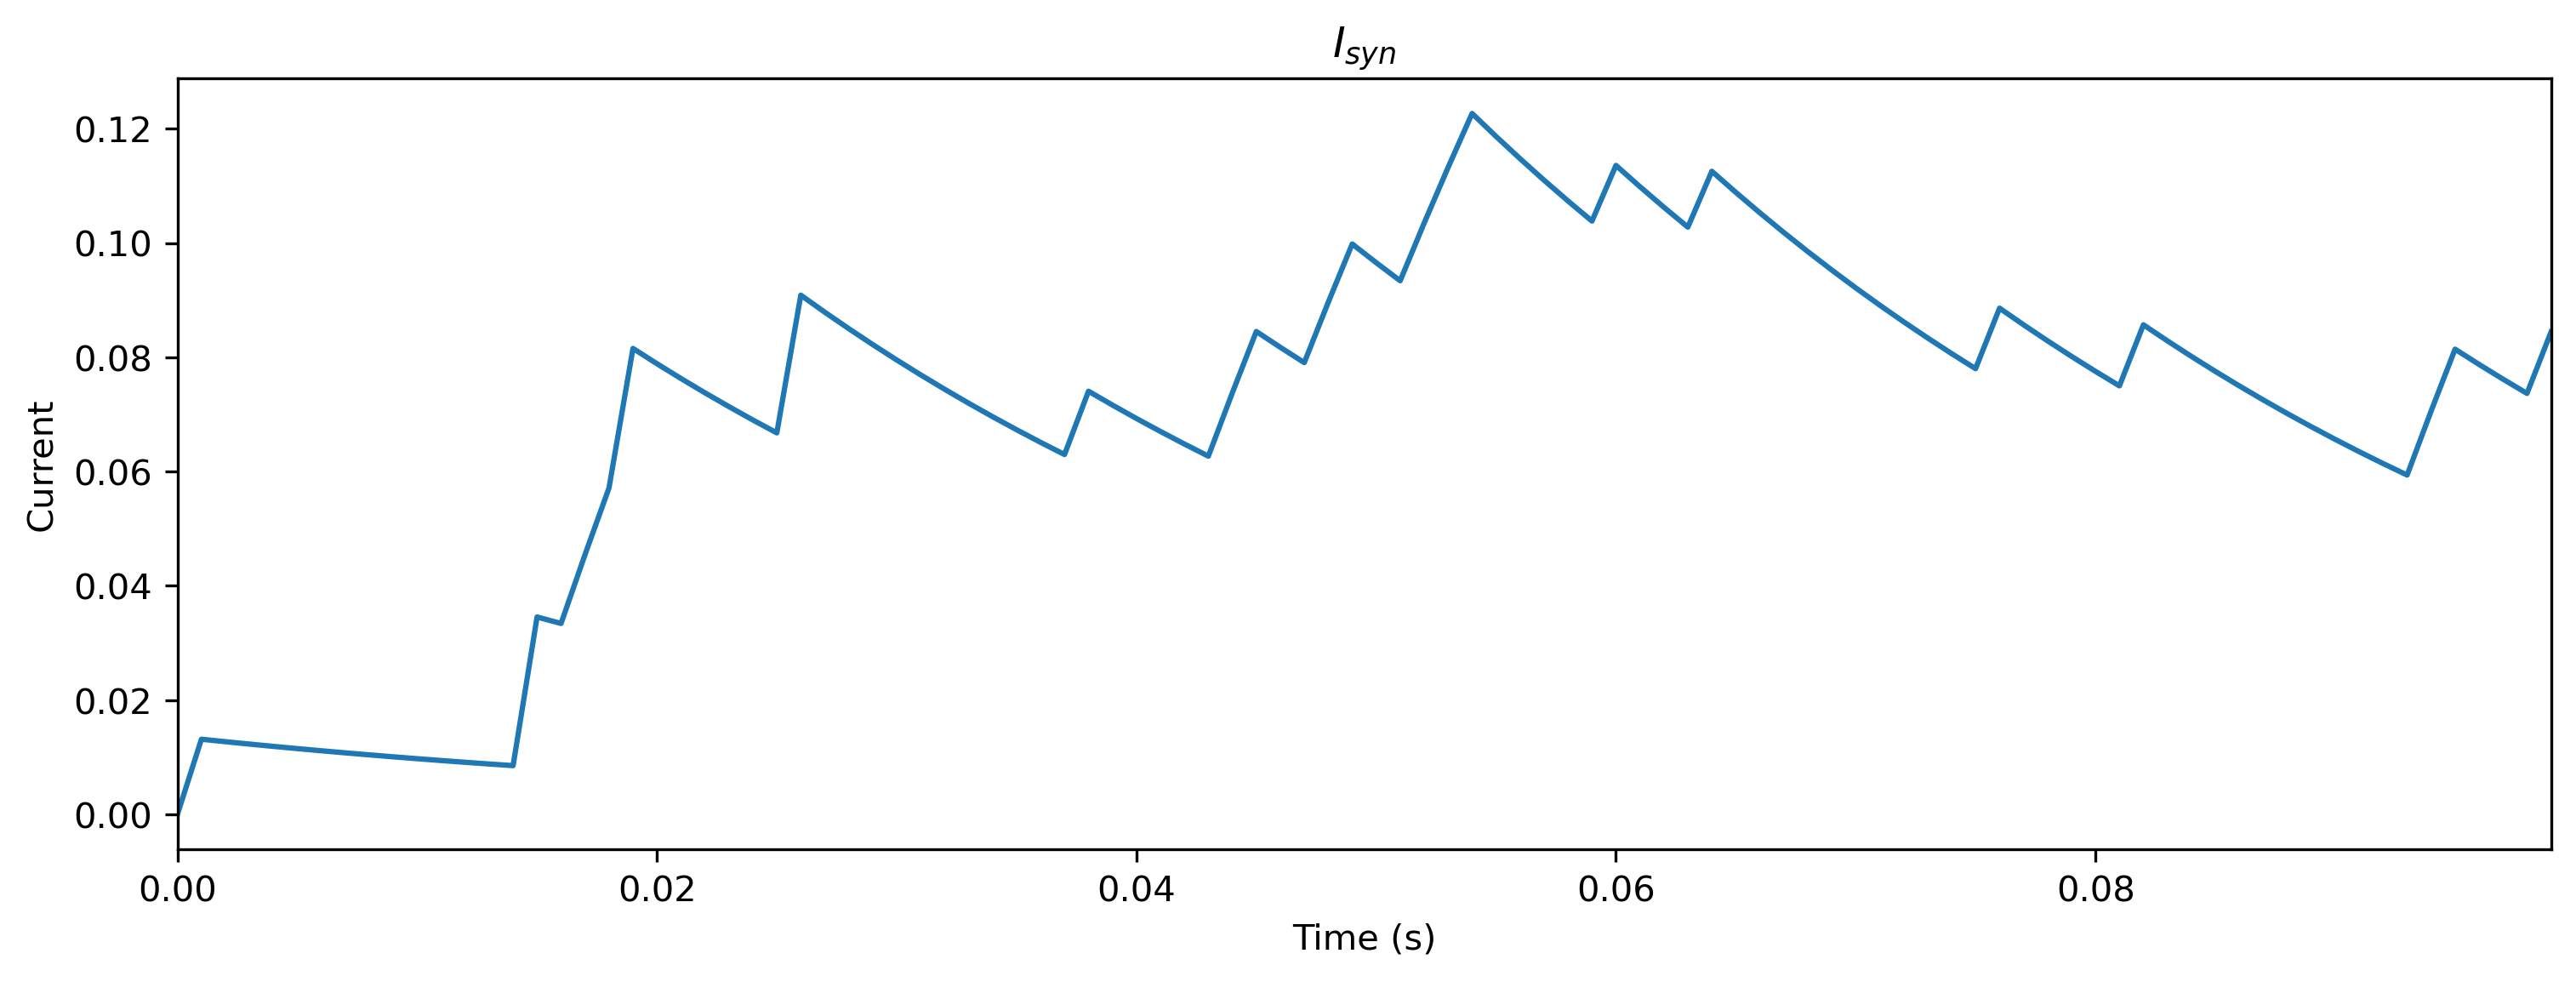

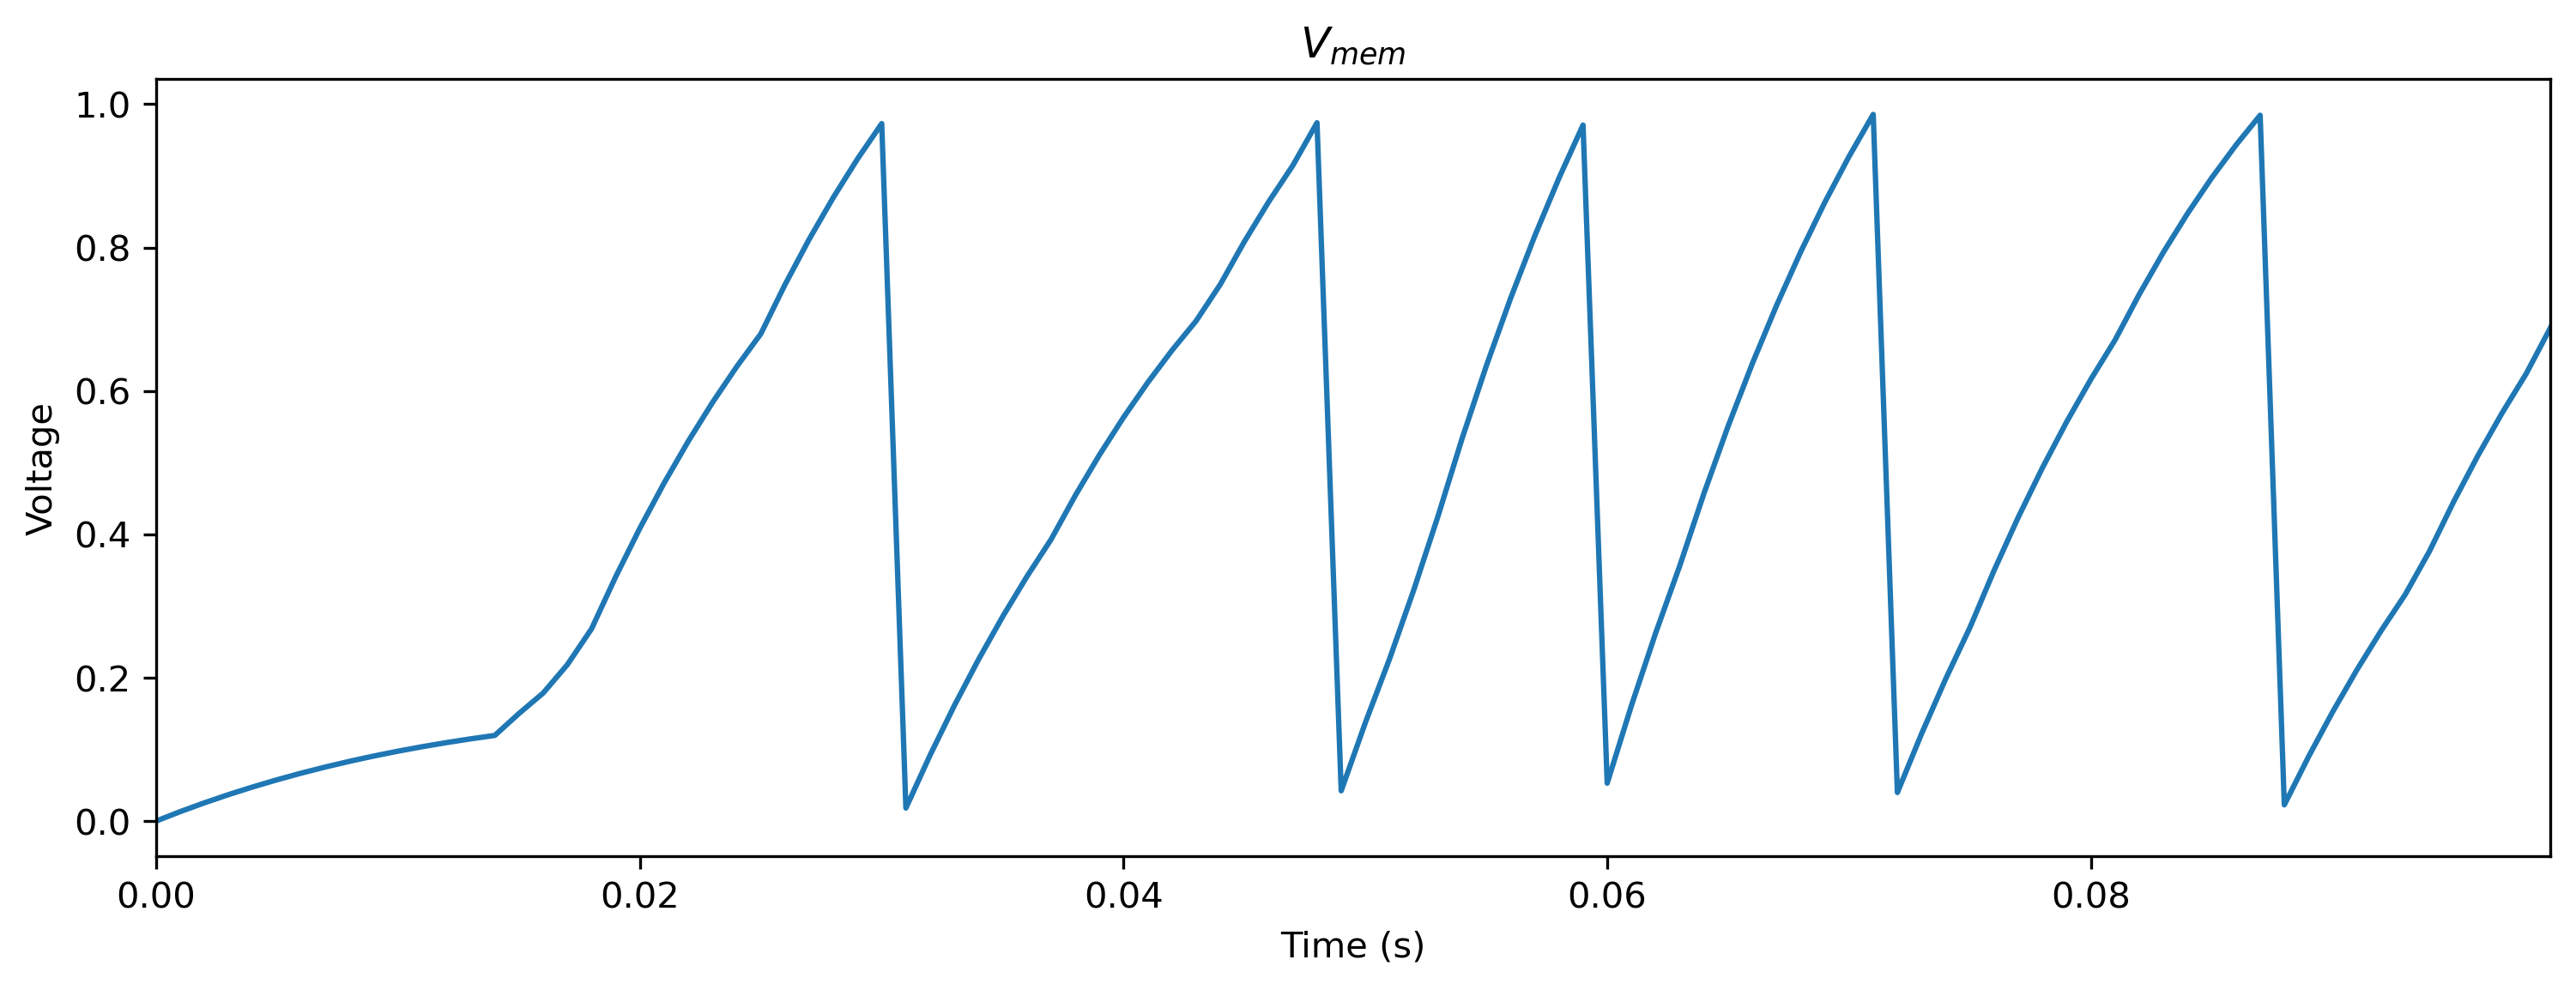

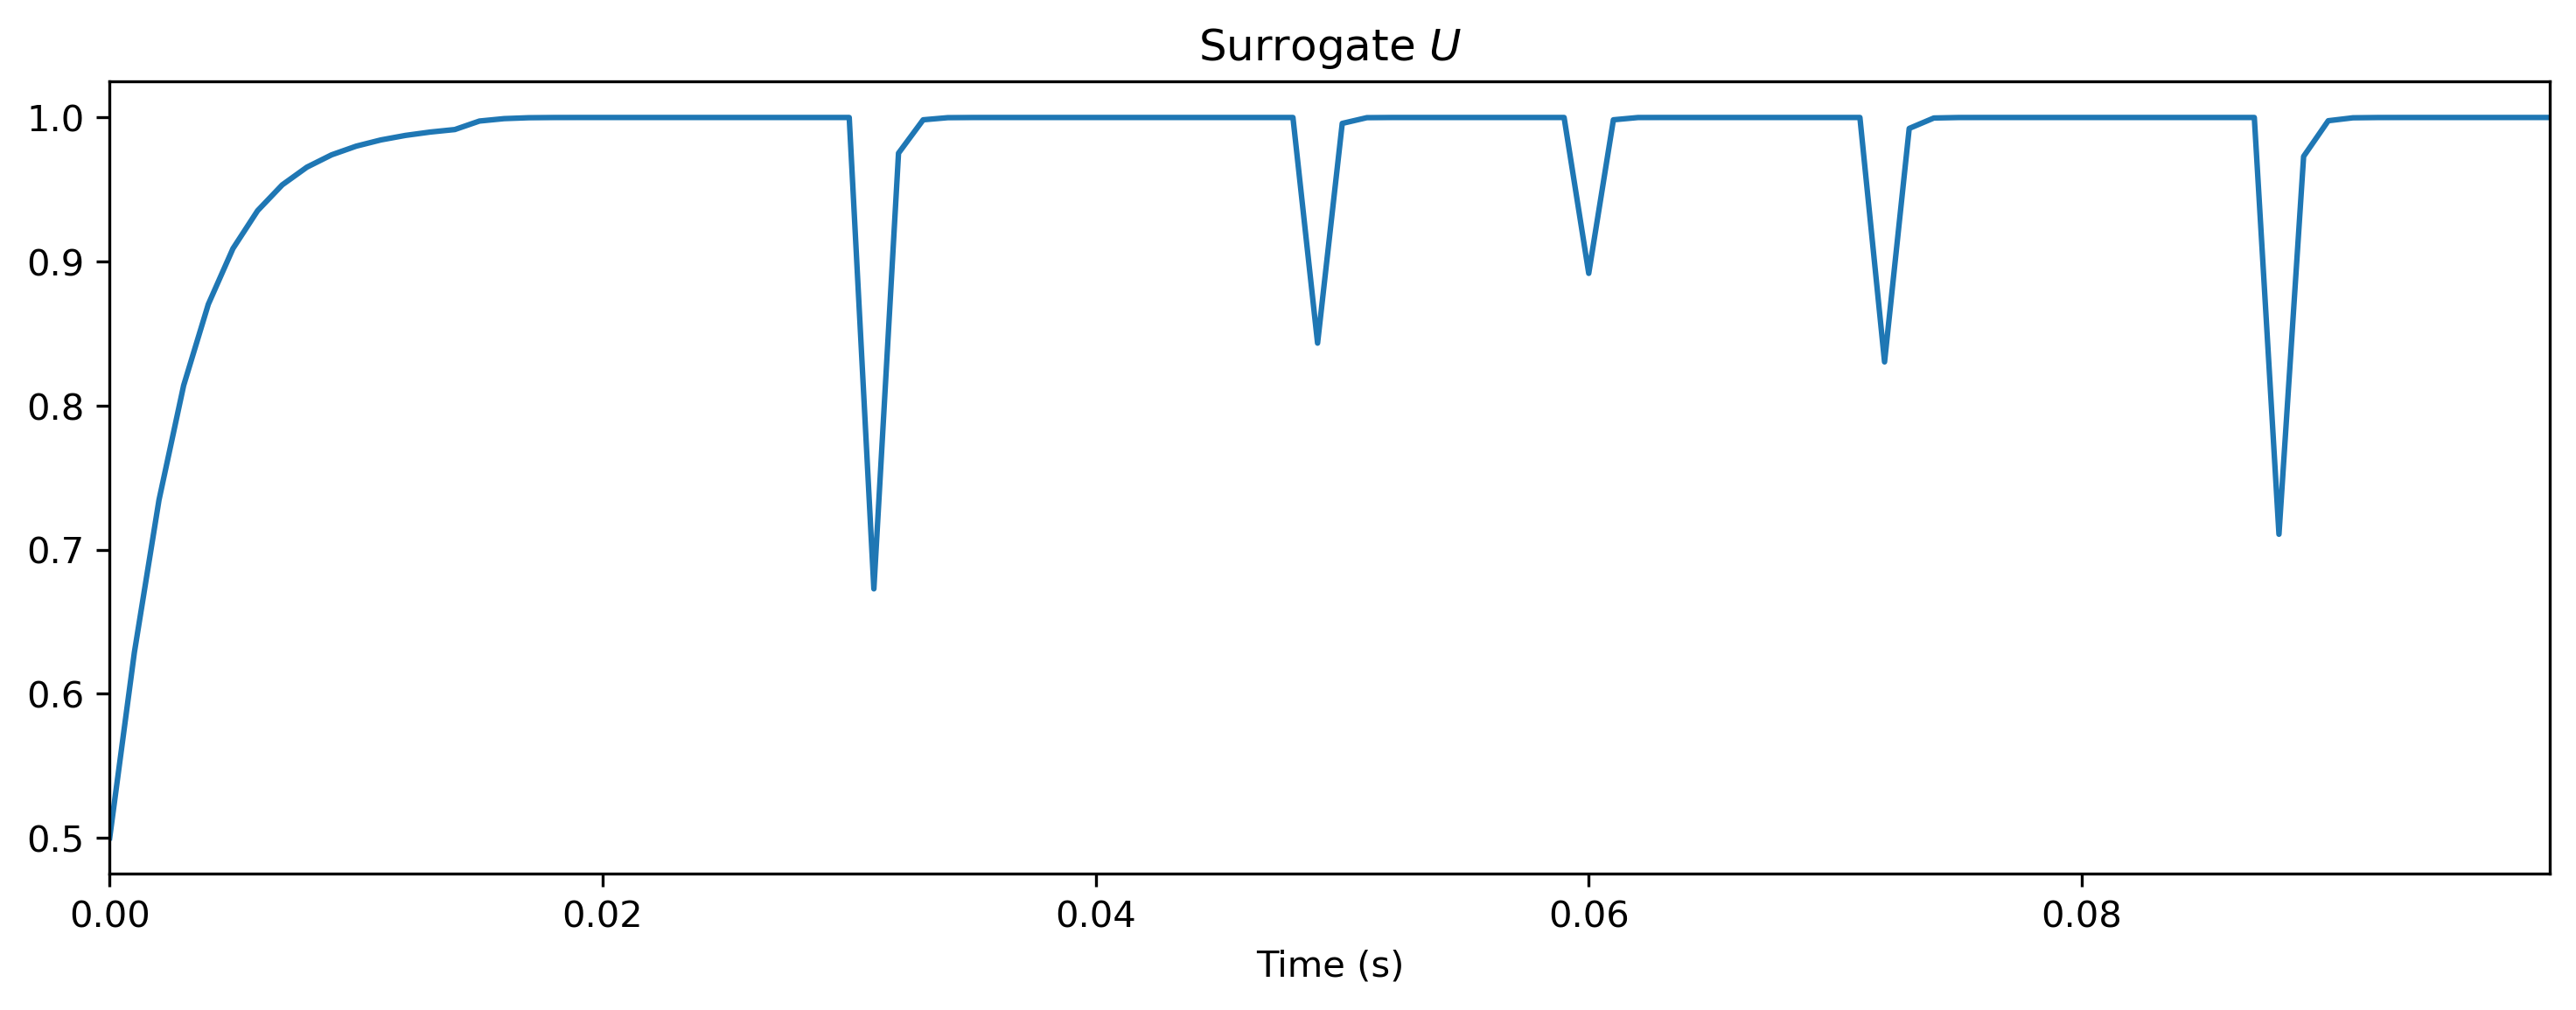

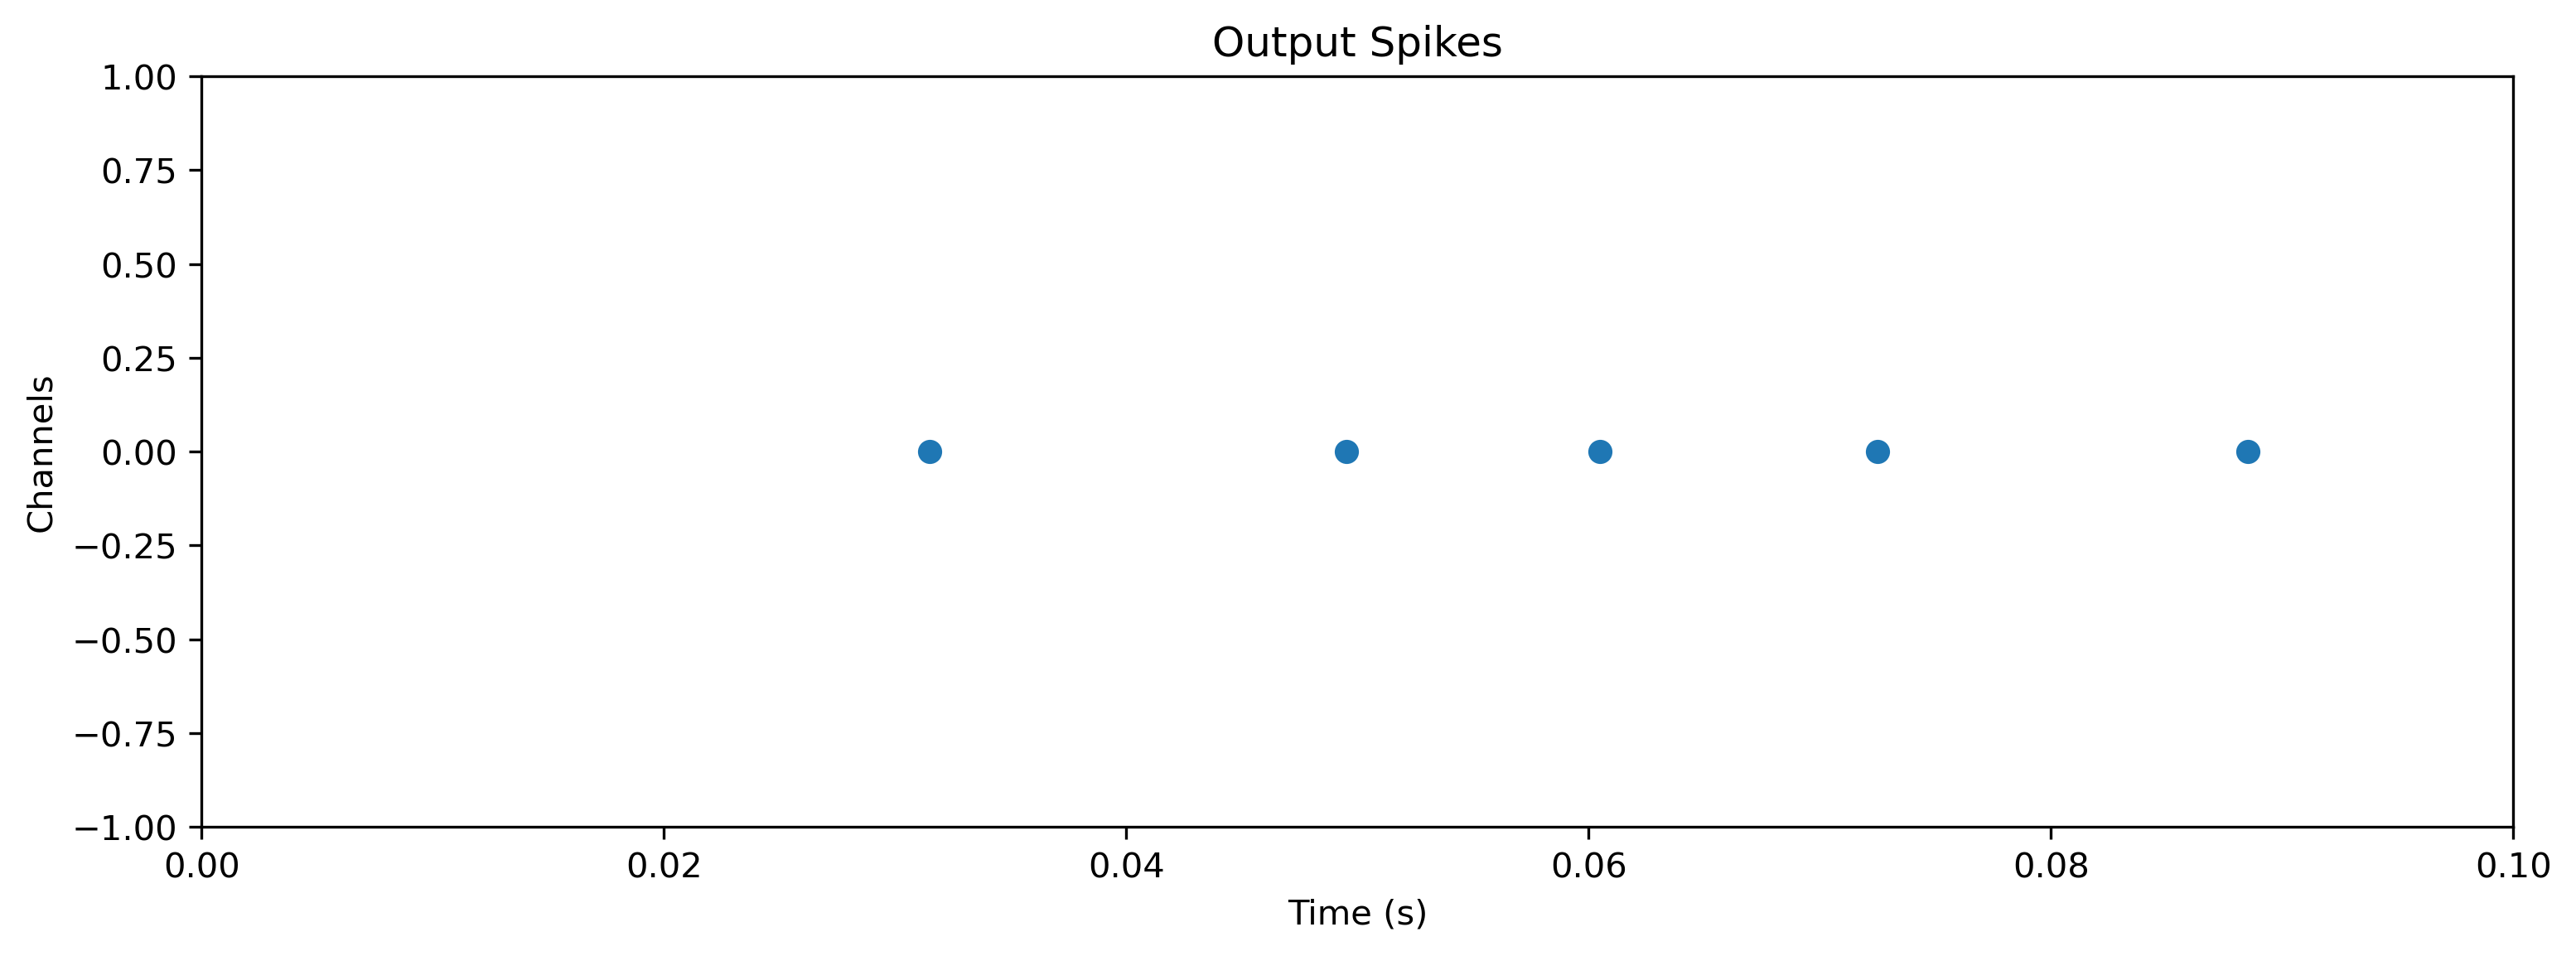

In [31]:
plot_LIF_record(rec['1_LIFTorch'])

Text(0.5, 0, 'epoch')

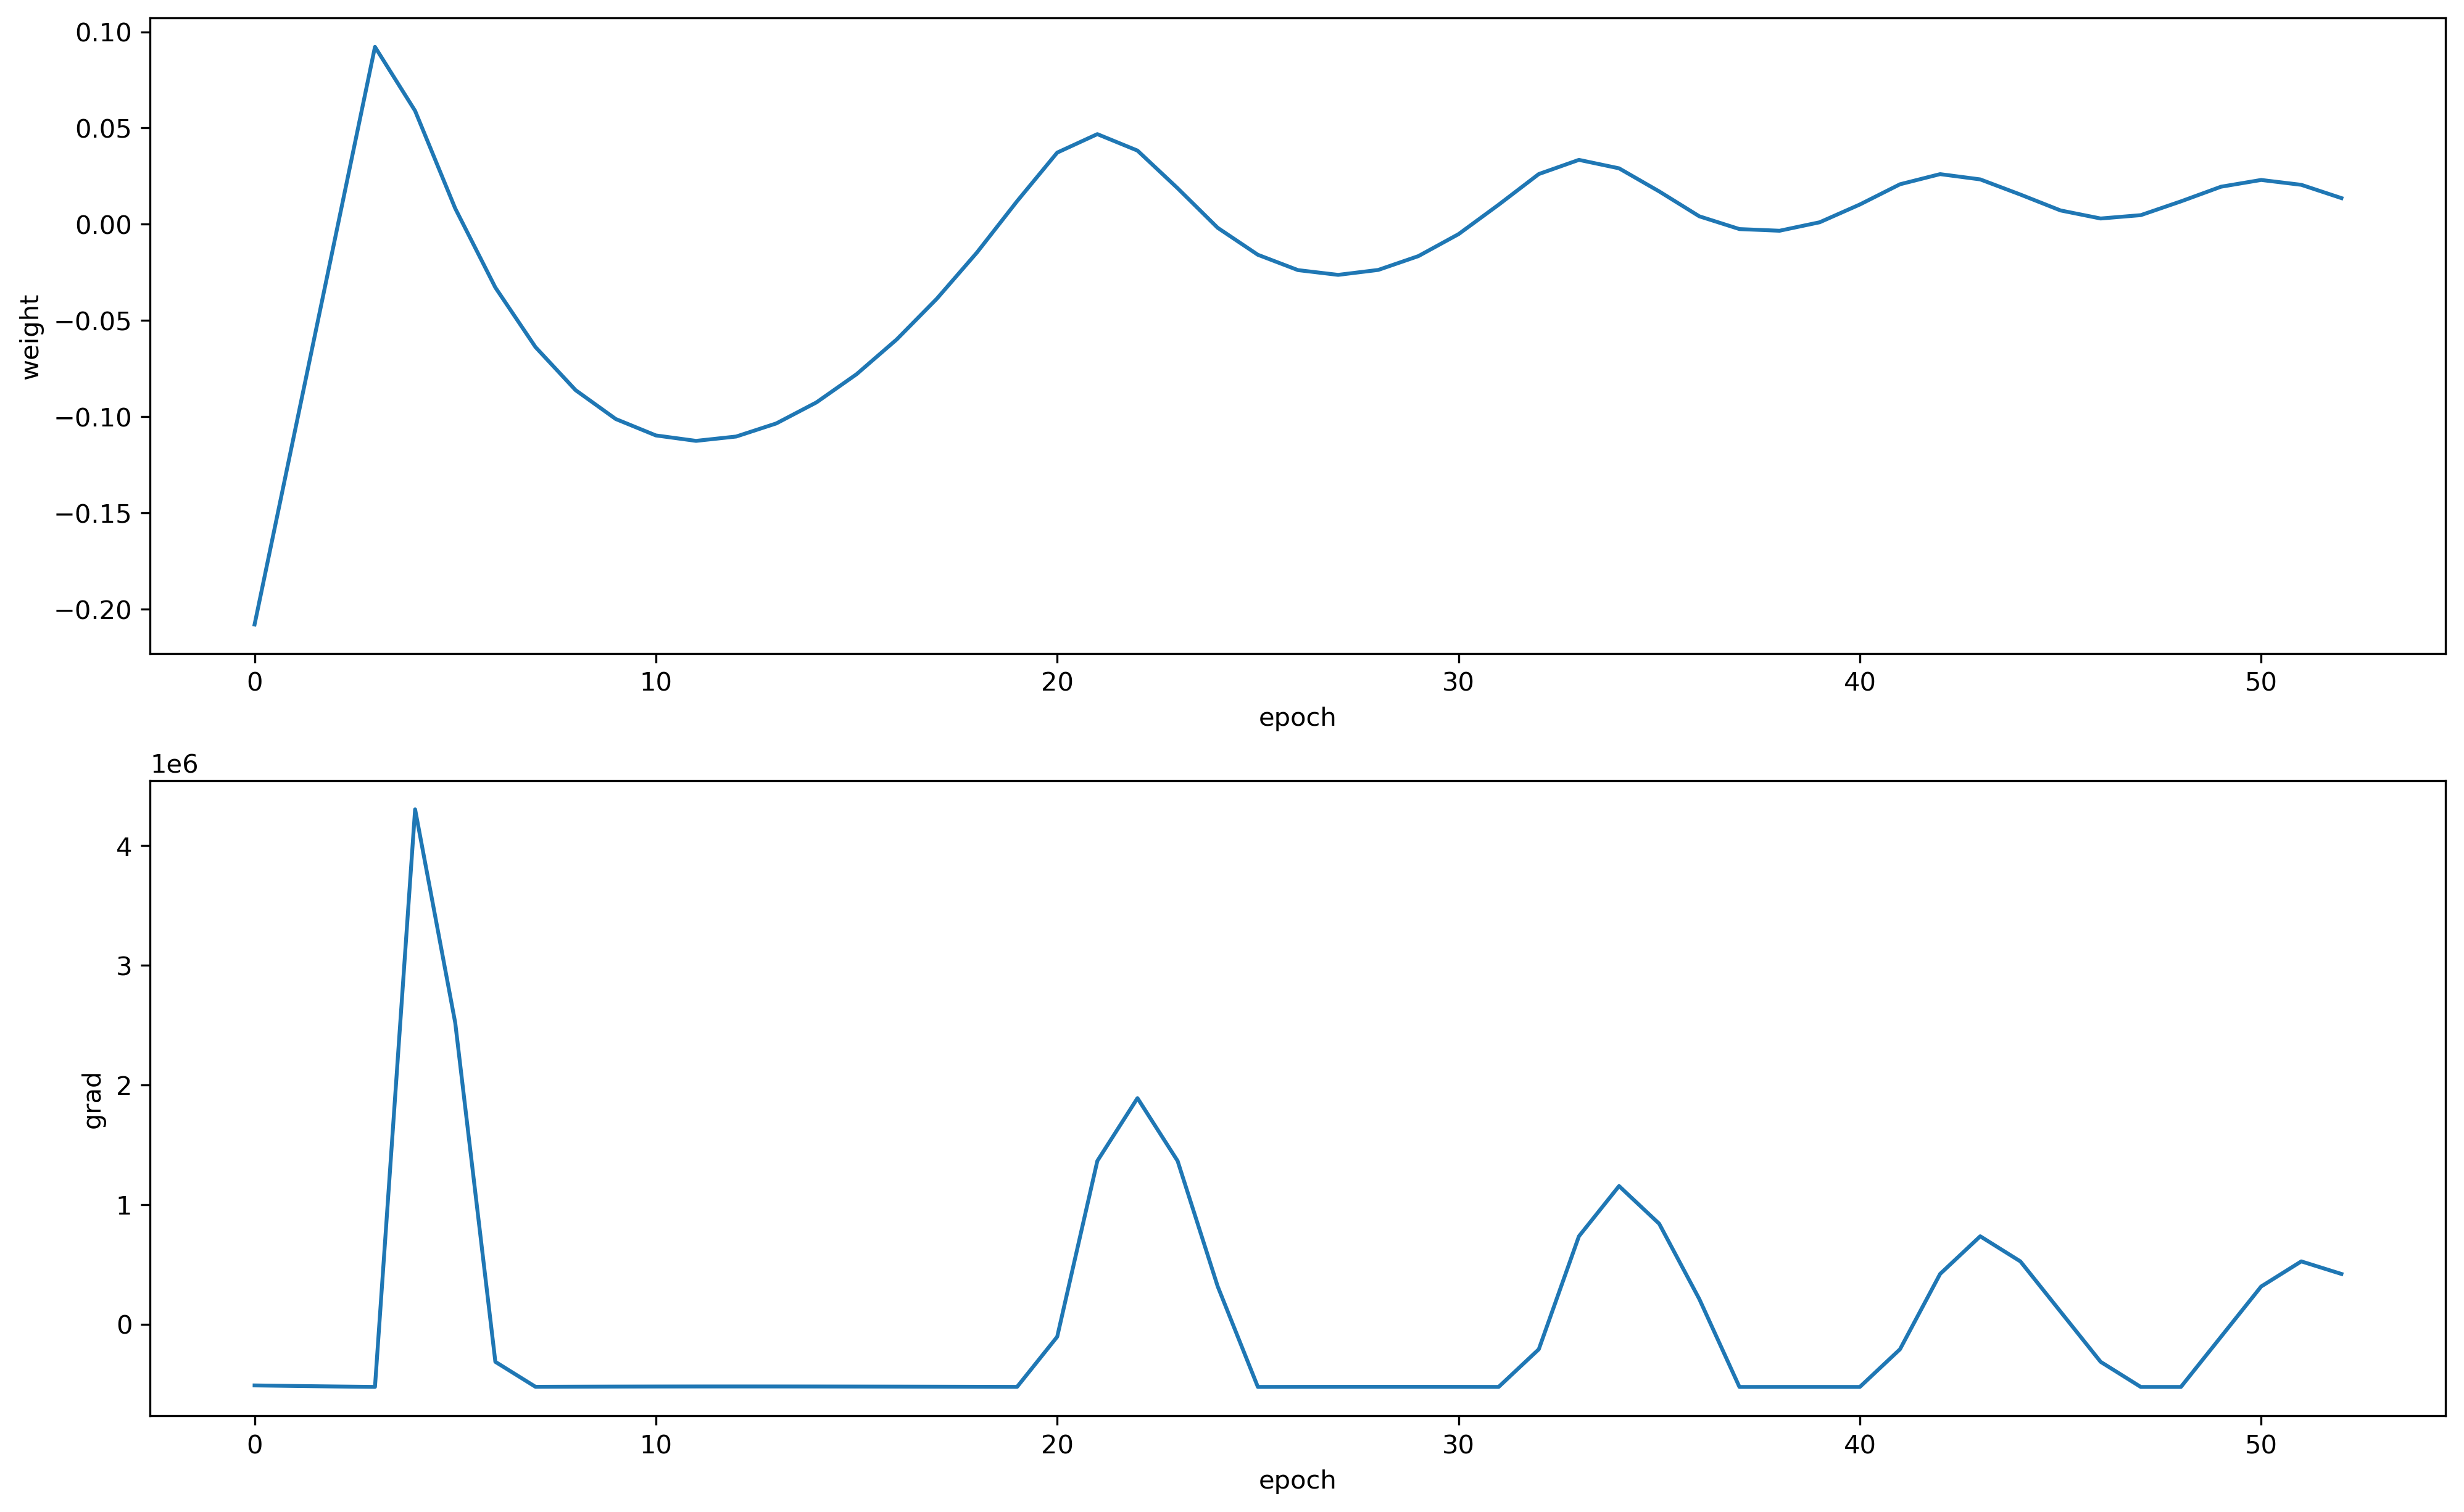

In [32]:
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(211)
plt.plot(param_trace)
plt.ylabel("weight")
plt.xlabel("epoch")
ax = fig.add_subplot(212)
plt.plot(grad_trace)
plt.ylabel("grad")
plt.xlabel("epoch")